# Synthetic Data

In [67]:
# import libraries

import warnings
warnings.filterwarnings('ignore')

# Import the numpy and pandas package
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import random
#import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import optimizers,initializers,regularizers

## 准备丹参数据 Data

In [68]:
data = pd.read_csv('D:\课题会\丹参\danshen_code\SDAE\SDAE-main\data\丹参数据salvia_all_20240425 - 副本.csv')

# 2. 删除前三列
data = data.iloc[:, 3:]
# 3. 删除指定目标变量
drop_cols = [
    'CS','MT','TSIIA','TSI','DTSI','SumTS','PD','CFA','FA','SAD','SF','DSS',
    'SAC','SAE','MCF','RA','SAA','LA','SAY','TA','CTA','MA','FMA','SUA','SAB',"Soil_sampleN",'etestN','testNp','etestpatch'
]
data = data.drop(columns=[col for col in drop_cols if col in data.columns])

# 4. 删除空白值较多的列
thresh = len(data) * 0.5
data = data.dropna(axis=1, thresh=thresh)

# 5. 去除剩余的缺失值样本（可选）
data = data.dropna(axis=0)


# 6. 指定需要独热编码的分类特征列
categorical_columns = [
    "Province",
    "City",
    "Microb",
    "etestN",
    "etestpatch",
    "testNp",
    "Landscape",
    "SoilType",
    "soilclass",      
    "CultivationType",
    "ClimateType",
    "按气候聚类划分的类型"
]
# 只对存在于数据中的列做独热编码
categorical_columns = [col for col in categorical_columns if col in data.columns]
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# 7 . 转为numpy数组
syn_data = data.to_numpy()

In [69]:
# 确保 data 目录存在（相对路径）
os.makedirs('./data', exist_ok=True)

# 保存为 data 目录下的 processed_danshen_data.csv
data.to_csv('./data/processed_danshen_data.csv', index=False)

In [70]:
syn_data.shape

(498, 141)

In [71]:
# Split to training and test 80:20
syn_data_train,syn_data_test = train_test_split(syn_data,test_size=0.2,random_state=42)

In [72]:
syn_data_train.shape

(398, 141)

In [73]:
print(data.dtypes)

Li_S                       float64
Be_S                       float64
Na_S                       float64
Mg_S                       float64
K_S                        float64
                            ...   
CultivationType_Unknown       bool
ClimateType_II                bool
ClimateType_III               bool
按气候聚类划分的类型_II                 bool
按气候聚类划分的类型_III                bool
Length: 141, dtype: object


In [74]:
#Pre-processing
scaler=StandardScaler()
syn_data_train_scal = scaler.fit_transform(syn_data_train)
syn_data_test_scal = scaler.transform(syn_data_test)

## SDAE functions

In [75]:
# 这段代码是SDAE（Selective Deep Auto-Encoder）核心的自定义层和模型结构定义，用于无监督特征选择。下面详细解释每一部分的含义和作用：
# Weighted layer defintion with zero-to-one clipping constraint and 1s initialzation with Lasso regularization

# 作用：这是一个自定义的 Keras 层，用于对输入特征进行加权选择。
# 关键点：
# self.kernel 是一组可训练参数（每个输入特征一个权重），初始值接近1。
# regularizer=regularizers.l1(self.lasso_rate)：L1正则化促使权重稀疏化（很多权重趋近于0），实现特征选择。
# constraint = ZeroToOneClip()：权重被限制在0~1之间。
# call 方法实现输入和权重的逐元素相乘，相当于“筛选”特征。
class SelectiveLayer(keras.layers.Layer):
    def __init__(self, lasso_rate=0.001,convergence_rate=0.001,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lasso_rate = lasso_rate
        #self.convergence_rate = convergence_rate
    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=(int(input_shape[-1]),), 
                                      initializer = initializers.RandomUniform(minval=0.999999, maxval=0.9999999),
                                      regularizer=regularizers.l1(self.lasso_rate),
                                      constraint = ZeroToOneClip()
                                     )
    def call(self, inputs):
        return tf.multiply(inputs, self.kernel)
    def get_config(self):
        config = super().get_config().copy()
        return config

#保证 SelectiveLayer 的权重始终在0~1之间，防止出现负权重或大于1的权重。
class ZeroToOneClip(tf.keras.constraints.Constraint):
    def __call__(self, w):
        w_new = tf.clip_by_value(w, 0, 1)
        return w_new


# 作用：构建 SDAE 的完整网络结构，返回多个模型对象。
# 结构说明：
# 输入层：feature_inputs
# 特征选择层：SelectiveLayer，对输入特征加权筛选。
# 编码器部分：
# encoder_layer_full：对原始输入做编码（全特征）。
# encoder_layer_select：对筛选后的特征做编码（被选择的特征）。
# 编码层：降维到 encodings_nbr 维。
# 解码器部分：对编码结果做解码，重建原始输入。
# 重建层：输出重建结果。
# 返回的模型：
# autoencoder：全特征自编码器（DAE）。
# autoencoder_select：选择特征自编码器（SelectDAE）。
# feature_selection_output：输出特征选择权重的模型。
# latent_encoder_full：全特征编码器。
# latent_encoder_select：选择特征编码器。
def SelectDAE(input_shape,
                  nbr_hidden_layers =1,
                  hidden_layer_shape=13,
                  encodings_nbr = 6,
                  activation="linear",
                  lasso_rate=0.01,
                  sl_lasso_rate=0.1):
    #Encoder 1:Input
    feature_inputs = Input(shape=[input_shape],name='input')
    #Encoder 2: Input
    selective_layer = SelectiveLayer(lasso_rate=sl_lasso_rate)
    feature_selection_choose = selective_layer(feature_inputs)
    
    for i in range(nbr_hidden_layers):
        #Encoder 1: hidden layers
        encoder_layer_full = Dense(hidden_layer_shape, activation=activation,
                            name='encoder_hidden_layer_full_'+str(i))
        #Encoder 2: hidden layers
        encoder_layer_select = Dense(hidden_layer_shape, activation=activation,
                            kernel_regularizer=regularizers.l1(lasso_rate),
                            bias_regularizer=regularizers.l1(lasso_rate),
                            name='encoder_hidden_layer_select_'+str(i))
        if i==0:
            encoder_layer_full_output = encoder_layer_full(feature_inputs)
            encoder_layer_select_output = encoder_layer_select(feature_selection_choose)
        else:
            encoder_layer_full_output = encoder_layer_full(encoder_layer_full_output)
            encoder_layer_select_output = encoder_layer_select(encoder_layer_select_output)
    
    #Encoder 1: Encodings
    encoding_layer_full = Dense(encodings_nbr, activation=activation,
                           name='encoding_layer_full')
    encoding_layer_full_output = encoding_layer_full(encoder_layer_full_output)
    
    #Encoder 2: Encodings
    encoding_layer_select = Dense(encodings_nbr, activation=activation,
                           kernel_regularizer=regularizers.l1(lasso_rate),
                           bias_regularizer=regularizers.l1(lasso_rate),
                           name='encoding_layer_select')
    encoding_layer_select_output = encoding_layer_select(encoder_layer_select_output)
    
    #Decoder Layers
    for i in range(nbr_hidden_layers):
        decoder_layer = Dense(hidden_layer_shape, activation=activation,
                            name='decoder_hidden_layer_'+str(i))
        if i==0:
            decoder_layer_full_output = decoder_layer(encoding_layer_full_output)
            decoder_layer_select_output = decoder_layer(encoding_layer_select_output)
        else:
            decoder_layer_full_output = decoder_layer(decoder_layer_full_output)
            decoder_layer_select_output = decoder_layer(decoder_layer_select_output)
    
    #Reconstruction Layer
    reconstruction_layer = Dense(input_shape, activation='linear',
                                 name='reconstruction_layer')
    recons_layer_full_output = reconstruction_layer(decoder_layer_full_output)
    recons_layer_select_output = reconstruction_layer(decoder_layer_select_output)

    latent_encoder_full = Model(feature_inputs, encoding_layer_full_output,name='fullFeats_Encoder')
    latent_encoder_select = Model(feature_inputs, encoding_layer_select_output,name='SelectFeats_Encoder')
    feature_selection_output=Model(feature_inputs,feature_selection_choose,name='SelectFeats_Layer')
    autoencoder = Model(feature_inputs, recons_layer_full_output,name='DAE')
    autoencoder_select = Model(feature_inputs, recons_layer_select_output,name='SelectDAE')   
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    
    print('SelectEncoder Structure-------------------------------------')
    latent_encoder_select.summary()
    
    return autoencoder,autoencoder_select,feature_selection_output, latent_encoder_full,latent_encoder_select

## Build Model

In [76]:
#parameters
lasso_rate = 1e-3
hidden_layer_shape = 12
nbr_hidden_layers =3
encodings_nbr = 6
LinearData = False
if LinearData:
    lasso_rate_SL=2e-3
else:
    lasso_rate_SL=1e-2
activation = "linear"
learning_rate = 1e-3
nbr_batches = 20
batch_size = int(np.floor(syn_data_train.shape[0]/nbr_batches))
seed = 0

#先用 random.seed 固定随机数生成器，然后再用 tf.random.set_seed 固定TensorFlow的随机性，保证每次实验结果一致。
random.seed(seed)
rndm_seed = random.randint(1,10000)
tf.random.set_seed(rndm_seed)

#初始化 SDAE 模型结构
#input_shape=syn_data_train.shape[1]：输入特征的数量。
DAE,\
Select_DAE,\
SelectLayer_output,\
FullFeats_Encoder,\
SelectFeats_Encoder=SelectDAE(input_shape=syn_data_train.shape[1],
                              nbr_hidden_layers = nbr_hidden_layers,
                              hidden_layer_shape=hidden_layer_shape,
                              encodings_nbr =encodings_nbr,
                              activation=activation,
                              lasso_rate=lasso_rate,
                              sl_lasso_rate=lasso_rate_SL)

Autoencoder Structure-------------------------------------
Model: "DAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 141)]             0         
                                                                 
 encoder_hidden_layer_full_0  (None, 12)               1704      
  (Dense)                                                        
                                                                 
 encoder_hidden_layer_full_1  (None, 12)               156       
  (Dense)                                                        
                                                                 
 encoder_hidden_layer_full_2  (None, 12)               156       
  (Dense)                                                        
                                                                 
 encoding_layer_full (Dense)  (None, 6)                78        
    

In [77]:
#Pre-training
## 1. 编译模型，指定损失函数和优化器
DAE.compile(loss='mean_squared_error',optimizer=optimizers.Adam())
## 2. 训练模型，指定训练数据、训练轮数、批次大小和是否打乱数据
DAE.fit(syn_data_train_scal,syn_data_train_scal,epochs=1000,batch_size=batch_size,\
                        shuffle=True
                       )

Epoch 1/1000
21/21 [==============================] - 0s 750us/step - loss: 1.0450
Epoch 2/1000
21/21 [==============================] - 0s 700us/step - loss: 0.9711
Epoch 2/1000
21/21 [==============================] - 0s 700us/step - loss: 0.9711
Epoch 3/1000
21/21 [==============================] - 0s 700us/step - loss: 0.8934
Epoch 3/1000
21/21 [==============================] - 0s 700us/step - loss: 0.8934
Epoch 4/1000
21/21 [==============================] - 0s 650us/step - loss: 0.8011
Epoch 4/1000
21/21 [==============================] - 0s 650us/step - loss: 0.8011
Epoch 5/1000
21/21 [==============================] - 0s 900us/step - loss: 0.7293
Epoch 5/1000
21/21 [==============================] - 0s 900us/step - loss: 0.7293
Epoch 6/1000
21/21 [==============================] - 0s 855us/step - loss: 0.6693
Epoch 7/1000
21/21 [==============================] - 0s 855us/step - loss: 0.6693
Epoch 7/1000
21/21 [==============================] - 0s 700us/step - loss: 0.6185
Epoc

In [78]:
# 3. 预测训练数据，并进行反归一化
train_prediction_all_feats_scal = DAE.predict(syn_data_train_scal)
train_prediction_all_feats = scaler.inverse_transform(train_prediction_all_feats_scal)
## 4. 打印训练结果
print('Training:')
print('MSE Full Scaled Feats: '+str(mean_squared_error(syn_data_train_scal,train_prediction_all_feats_scal)))
print('MSE Full Real Feats: '+str(mean_squared_error(syn_data_train,train_prediction_all_feats)))

13/13 [==============================] - 0s 500us/step
Training:
MSE Full Scaled Feats: 0.3981188153683945
MSE Full Real Feats: 656505.5962480578
Training:
MSE Full Scaled Feats: 0.3981188153683945
MSE Full Real Feats: 656505.5962480578


In [79]:
# 5. 预测测试数据，并进行反归一化
test_prediction_all_feats_scal = DAE.predict(syn_data_test_scal)
test_prediction_all_feats = scaler.inverse_transform(test_prediction_all_feats_scal)
## 6. 打印测试结果
print("Testing:")
print('MSE Full Scaled Feats: '+str(mean_squared_error(syn_data_test_scal,test_prediction_all_feats_scal)))
print('MSE Full Real Feats: '+str(mean_squared_error(syn_data_test,test_prediction_all_feats)))

4/4 [==============================] - 0s 1ms/step
Testing:
MSE Full Scaled Feats: 0.4933229415841282
MSE Full Real Feats: 826283.5790978089
4/4 [==============================] - 0s 1ms/step
Testing:
MSE Full Scaled Feats: 0.4933229415841282
MSE Full Real Feats: 826283.5790978089


In [80]:
#Transfer Learning
# 1. 将全特征编码器（FullFeats_Encoder）的权重转移到选择特征编码器（SelectFeats_Encoder）
for lay in range(nbr_hidden_layers+1):
    SelectFeats_Encoder.layers[-(1+lay)].set_weights(FullFeats_Encoder.layers[-(1+lay)].get_weights())

In [81]:
# Feature Selection Training
## 1. 编译模型，指定损失函数和优化器
SelectFeats_Encoder.compile(loss='mean_squared_error',optimizer=optimizers.Adam())
## 2. 预测训练数据，并进行反归一化
DAE_encodings_train_scal = FullFeats_Encoder.predict(syn_data_train_scal)
SelectFeats_Encoder.fit(syn_data_train_scal,DAE_encodings_train_scal,epochs=2500,batch_size=batch_size,\
                        shuffle=True)

13/13 [==============================] - 0s 417us/step
Epoch 1/2500
Epoch 1/2500
21/21 [==============================] - 0s 700us/step - loss: 1.6339
Epoch 2/2500
21/21 [==============================] - 0s 650us/step - loss: 1.5918
Epoch 2/2500
21/21 [==============================] - 0s 650us/step - loss: 1.5918
Epoch 3/2500
21/21 [==============================] - 0s 614us/step - loss: 1.5513
Epoch 3/2500
21/21 [==============================] - 0s 614us/step - loss: 1.5513
Epoch 4/2500
21/21 [==============================] - 0s 650us/step - loss: 1.5119
Epoch 4/2500
21/21 [==============================] - 0s 650us/step - loss: 1.5119
Epoch 5/2500
21/21 [==============================] - 0s 650us/step - loss: 1.4735
Epoch 5/2500
21/21 [==============================] - 0s 650us/step - loss: 1.4735
Epoch 6/2500
21/21 [==============================] - 0s 650us/step - loss: 1.4359
Epoch 6/2500
21/21 [==============================] - 0s 650us/step - loss: 1.4359
Epoch 7/2500
21/21 

In [82]:
## 3. 预测训练数据，并进行反归一化
train_prediction_select_feats_scal = Select_DAE.predict(syn_data_train_scal)
train_prediction_select_feats = scaler.inverse_transform(train_prediction_select_feats_scal)
## 4. 打印训练结果
print('Training:')
print('MSE Select Scaled Feats: '+str(mean_squared_error(syn_data_train_scal,train_prediction_select_feats_scal)))
print('MSE Select Real Feats: '+str(mean_squared_error(syn_data_train,train_prediction_select_feats)))

13/13 [==============================] - 0s 583us/step
Training:
MSE Select Scaled Feats: 0.39964709424473066
MSE Select Real Feats: 659396.644138715
Training:
MSE Select Scaled Feats: 0.39964709424473066
MSE Select Real Feats: 659396.644138715


In [ ]:
# 5. 打印重要特征数量和权重
survived_feats = len(np.where(SelectLayer_output.layers[1].get_weights()[0]>=1e-2)[0])
print('Number of Important Features = '+str(survived_feats))

Number of Important Features = 52


In [84]:
# 6. 打印重要特征权重
wghts_final = SelectLayer_output.layers[1].get_weights()[0]
# print(wghts_final.reshape(wghts_final.shape[0]//4,4))
print("特征权重 shape:", wghts_final.shape)
print("特征权重:", wghts_final)

特征权重 shape: (141,)
特征权重: [5.5246528e-02 0.0000000e+00 2.8562186e-02 0.0000000e+00 0.0000000e+00
 5.3737141e-02 7.5134292e-02 3.8612612e-02 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.9409518e-02 5.6326076e-02 0.0000000e+00
 3.6870878e-02 0.0000000e+00 0.0000000e+00 3.3629924e-02 0.0000000e+00
 4.2903116e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.7508965e-02
 0.0000000e+00 8.5794619e-07 3.4313183e-02 4.4653032e-02 2.7465399e-02
 5.9610832e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.3674721e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.3572342e-02 0.0000000e+00 4.0790182e-02 0.0000000e+00 3.1973358e-02
 0.0000000e+00 0.0000000e+00 2.6217572e-02 3.7044089e-02 0.0000000e+00
 2.8224202e-02 0.0000000e+00 2.9766452e-02 2.5445895e-02 2.3640316e-02
 2.6530977e-02 0.0000000e+00 0.0000000e+00 4.5451988e-02 1.5943173e-02
 0.0000000e+00 6.7640968e-02 0.0000000e+00 2.8942697e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9192152

In [85]:
# 1. 定义分组

soil_elements = ['Li_S','Be_S','Na_S','Mg_S','K_S','Ca_S','Sc_S','Ti_S','V_S','Cr_S','Mn_S','Fe_S','Co_S','Ni_S','Cu_S','Zn_S','Ga_S','Ge_S','As_S','Rb_S','Sr_S','Y_S','Zr_S','Nb_S','Mo_S','Cd_S','Sn_S','Sb_S','Cs_S','Ba_S','La_S','Ce_S','Pr_S','Nd_S','Sm_S','Eu_S','Gd_S','Tb_S','Dy_S','Ho_S','Er_S','Yb_S','Hf_S','Pb_S','Th_S']
crop_elements = ['Li_P','Be_P','Na_P','Mg_P','K_P','Ca_P','Sc_P','Ti_P','V_P','Cr_P','Mn_P','Fe_P','Co_P','Ni_P','Cu_P','Zn_P','Ga_P','Ge_P','As_P','Rb_P','Sr_P','Y_P','Zr_P','Nb_P','Mo_P','Cd_P','Sn_P','Sb_P','Cs_P','Ba_P','La_P','Ce_P','Pr_P','Nd_P','Sm_P','Eu_P','Gd_P','Tb_P','Dy_P','Ho_P','Er_P','Yb_P','Hf_P','Pb_P','Th_P']
nutrients = ['AN','AP','AK','pH','EC','NH4_N','NO3_N','N.N','TN','OM']
geo = ['Longitude','Latitude','Altitude','R_Altitude','ALT_extract']
climate = ['DI','GDD0','GDD5','GP','MI','MTCO','MTWA','Tmax','Tmin']
province = [f'Province_{x}' for x in ['Hebei','Henan','Shandong','Shannxi','Shanxi','Sichuan']]
city = [f'City_{x}' for x in ['Bozhou','Deyang','Guangyuan','Heze','Jinan','Linyi','Nanyang','Sanmenxia','Shangluo','Yuncheng']]
landscape = ['Landscape_Hills','Landscape_Mountain','Landscape_Slope']
soiltype = ['SoilType_Roam','SoilType_Sandy']
cultivation = ['CultivationType_Seedings','CultivationType_Unknown']
climate_type = ['ClimateType_II','ClimateType_III','按气候聚类划分的类型_II','按气候聚类划分的类型_III']

groups = [
    ('土壤元素', soil_elements),
    ('作物元素', crop_elements),
    ('土壤养分', nutrients),
    ('地理信息', geo),
    ('气候环境', climate),
    ('省份', province),
    ('城市', city),
    ('地貌', landscape),
    ('土壤类型', soiltype),
    ('栽培类型', cultivation),
    ('气候类型', climate_type)
]

# 2. 分组展示
feature_names = data.columns.tolist()
for group_name, group_feats in groups:
    print(f"\n【{group_name}】")
    for feat in group_feats:
        if feat in feature_names:
            idx = feature_names.index(feat)
            print(f"{feat}: {wghts_final[idx]:.6f}")


【土壤元素】
Li_S: 0.055247
Be_S: 0.000000
Na_S: 0.028562
Mg_S: 0.000000
K_S: 0.000000
Ca_S: 0.053737
Sc_S: 0.075134
Ti_S: 0.038613
V_S: 0.000000
Cr_S: 0.000000
Mn_S: 0.000000
Fe_S: 0.000000
Co_S: 0.059410
Ni_S: 0.056326
Cu_S: 0.000000
Zn_S: 0.036871
Ga_S: 0.000000
Ge_S: 0.000000
As_S: 0.033630
Rb_S: 0.000000
Sr_S: 0.000004
Y_S: 0.000000
Zr_S: 0.000000
Nb_S: 0.000000
Mo_S: 0.037509
Cd_S: 0.000000
Sn_S: 0.000001
Sb_S: 0.034313
Cs_S: 0.044653
Ba_S: 0.027465
La_S: 0.059611
Ce_S: 0.000000
Pr_S: 0.000000
Nd_S: 0.000000
Sm_S: 0.083675
Eu_S: 0.000000
Gd_S: 0.000000
Tb_S: 0.000000
Dy_S: 0.000000
Ho_S: 0.000000
Er_S: 0.053572
Yb_S: 0.000000
Hf_S: 0.040790
Pb_S: 0.000000
Th_S: 0.031973

【作物元素】
Li_P: 0.028224
Be_P: 0.000000
Na_P: 0.029766
Mg_P: 0.025446
K_P: 0.023640
Ca_P: 0.026531
Sc_P: 0.000000
Ti_P: 0.000000
V_P: 0.045452
Cr_P: 0.015943
Mn_P: 0.000000
Fe_P: 0.067641
Co_P: 0.000000
Ni_P: 0.028943
Cu_P: 0.000000
Zn_P: 0.000000
Ga_P: 0.000000
Ge_P: 0.000000
As_P: 0.029192
Rb_P: 0.000000
Sr_P: 0.035076

In [86]:
# 统计并输出每个特征组的平均权重
group_avg_weights = []
for group_name, group_feats in groups:
    feats_in_data = [f for f in group_feats if f in feature_names]
    if feats_in_data:
        idxs = [feature_names.index(f) for f in feats_in_data]
        weights = [wghts_final[i] for i in idxs]
        avg_weight = np.mean(np.abs(weights))
        group_avg_weights.append((group_name, avg_weight, len(feats_in_data)))
print('\n各特征组平均权重（绝对值）及特征数：')
for group_name, avg_weight, n_feats in group_avg_weights:
    print(f'{group_name:<12} 平均权重: {avg_weight:.4f}  特征数: {n_feats}')
group_avg_weights_sorted = sorted(group_avg_weights, key=lambda x: -x[1])
print('\n按平均权重排序：')
for group_name, avg_weight, n_feats in group_avg_weights_sorted:
    print(f'{group_name:<12} 平均权重: {avg_weight:.4f}  特征数: {n_feats}')


各特征组平均权重（绝对值）及特征数：
土壤元素         平均权重: 0.0189  特征数: 45
作物元素         平均权重: 0.0157  特征数: 45
土壤养分         平均权重: 0.0162  特征数: 10
地理信息         平均权重: 0.0140  特征数: 5
气候环境         平均权重: 0.0288  特征数: 9
省份           平均权重: 0.0341  特征数: 6
城市           平均权重: 0.0000  特征数: 10
地貌           平均权重: 0.0000  特征数: 3
土壤类型         平均权重: 0.0000  特征数: 2
栽培类型         平均权重: 0.0177  特征数: 2
气候类型         平均权重: 0.0240  特征数: 4

按平均权重排序：
省份           平均权重: 0.0341  特征数: 6
气候环境         平均权重: 0.0288  特征数: 9
气候类型         平均权重: 0.0240  特征数: 4
土壤元素         平均权重: 0.0189  特征数: 45
栽培类型         平均权重: 0.0177  特征数: 2
土壤养分         平均权重: 0.0162  特征数: 10
作物元素         平均权重: 0.0157  特征数: 45
地理信息         平均权重: 0.0140  特征数: 5
城市           平均权重: 0.0000  特征数: 10
地貌           平均权重: 0.0000  特征数: 3
土壤类型         平均权重: 0.0000  特征数: 2


In [87]:
# 统计并输出每个特征组的平均权重（仅统计权重不为0的特征）
group_avg_weights_nonzero = []
for group_name, group_feats in groups:
    feats_in_data = [f for f in group_feats if f in feature_names]
    if feats_in_data:
        idxs = [feature_names.index(f) for f in feats_in_data]
        weights = [wghts_final[i] for i in idxs]
        nonzero_weights = [w for w in weights if abs(w) > 1e-8]
        if nonzero_weights:
            avg_weight = np.mean(np.abs(nonzero_weights))
            group_avg_weights_nonzero.append((group_name, avg_weight, len(nonzero_weights)))
        else:
            group_avg_weights_nonzero.append((group_name, 0, 0))
print('\n各特征组平均权重（仅统计权重不为0的特征，绝对值）及特征数：')
for group_name, avg_weight, n_feats in group_avg_weights_nonzero:
    print(f'{group_name:<12} 平均权重: {avg_weight:.4f}  非零特征数: {n_feats}')
group_avg_weights_nonzero_sorted = sorted(group_avg_weights_nonzero, key=lambda x: -x[1])
print('\n按平均权重排序（仅统计非零权重特征）：')
for group_name, avg_weight, n_feats in group_avg_weights_nonzero_sorted:
    print(f'{group_name:<12} 平均权重: {avg_weight:.4f}  非零特征数: {n_feats}')


各特征组平均权重（仅统计权重不为0的特征，绝对值）及特征数：
土壤元素         平均权重: 0.0426  非零特征数: 20
作物元素         平均权重: 0.0393  非零特征数: 18
土壤养分         平均权重: 0.0325  非零特征数: 5
地理信息         平均权重: 0.0699  非零特征数: 1
气候环境         平均权重: 0.0648  非零特征数: 4
省份           平均权重: 0.0512  非零特征数: 4
城市           平均权重: 0.0000  非零特征数: 1
地貌           平均权重: 0.0000  非零特征数: 0
土壤类型         平均权重: 0.0000  非零特征数: 0
栽培类型         平均权重: 0.0355  非零特征数: 1
气候类型         平均权重: 0.0958  非零特征数: 1

按平均权重排序（仅统计非零权重特征）：
气候类型         平均权重: 0.0958  非零特征数: 1
地理信息         平均权重: 0.0699  非零特征数: 1
气候环境         平均权重: 0.0648  非零特征数: 4
省份           平均权重: 0.0512  非零特征数: 4
土壤元素         平均权重: 0.0426  非零特征数: 20
作物元素         平均权重: 0.0393  非零特征数: 18
栽培类型         平均权重: 0.0355  非零特征数: 1
土壤养分         平均权重: 0.0325  非零特征数: 5
城市           平均权重: 0.0000  非零特征数: 1
地貌           平均权重: 0.0000  非零特征数: 0
土壤类型         平均权重: 0.0000  非零特征数: 0


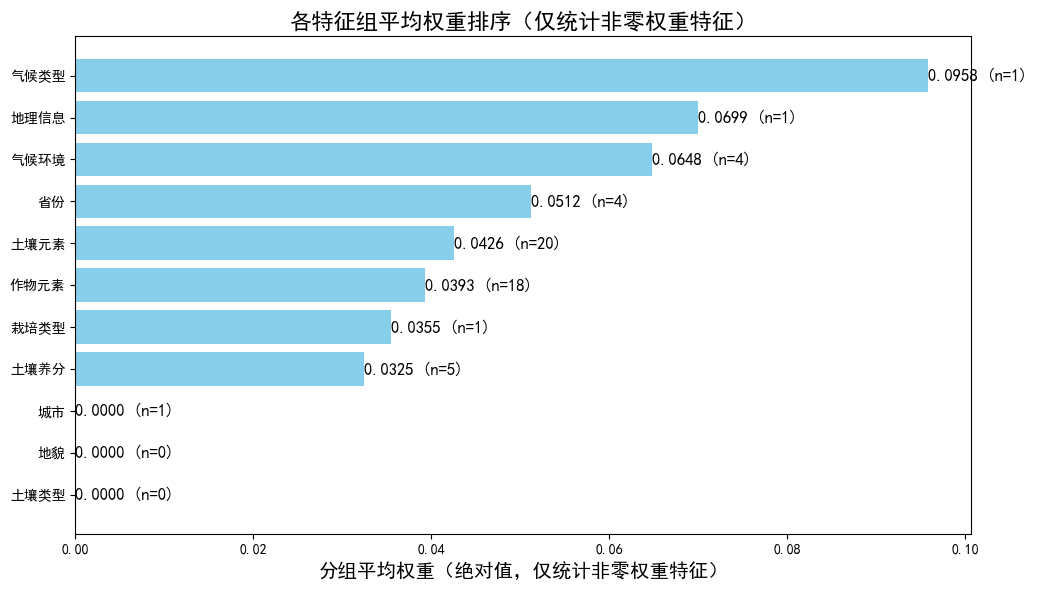

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# 可视化分组平均权重（仅统计非零权重特征）
group_names = [x[0] for x in group_avg_weights_nonzero_sorted]
avg_weights = [x[1] for x in group_avg_weights_nonzero_sorted]
nonzero_counts = [x[2] for x in group_avg_weights_nonzero_sorted]

plt.figure(figsize=(10, 6))
bars = plt.barh(group_names[::-1], avg_weights[::-1], color='skyblue')
plt.xlabel('分组平均权重（绝对值，仅统计非零权重特征）', fontsize=14)
plt.title('各特征组平均权重排序（仅统计非零权重特征）', fontsize=16)
plt.tight_layout()

# 在条形图右侧显示数值
for bar, count, weight in zip(bars, nonzero_counts[::-1], avg_weights[::-1]):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f} (n={count})', va='center', fontsize=12)

plt.show()

In [89]:
# 7. 预测测试数据，并进行反归一化
test_prediction_select_feats_scal = Select_DAE.predict(syn_data_test_scal)
test_prediction_select_feats = scaler.inverse_transform(test_prediction_select_feats_scal)
print('Testing:')
print('MSE Select Scaled Feats: '+str(mean_squared_error(syn_data_test_scal,test_prediction_select_feats_scal)))
print('MSE Select Real Feats: '+str(mean_squared_error(syn_data_test,test_prediction_select_feats)))

4/4 [==============================] - 0s 1ms/step
Testing:
MSE Select Scaled Feats: 0.49565142450066113
MSE Select Real Feats: 810967.9063003316
4/4 [==============================] - 0s 1ms/step
Testing:
MSE Select Scaled Feats: 0.49565142450066113
MSE Select Real Feats: 810967.9063003316


In [90]:
# Nonlinear Reconstruction
# 1. 打印非线性重构误差
if not LinearData:
    print('Nonlinear Reconstruction Error = ')
    print(mean_squared_error(syn_data_test[:,-12:],test_prediction_select_feats[:,-12:]))

Nonlinear Reconstruction Error = 
0.07643056407839978


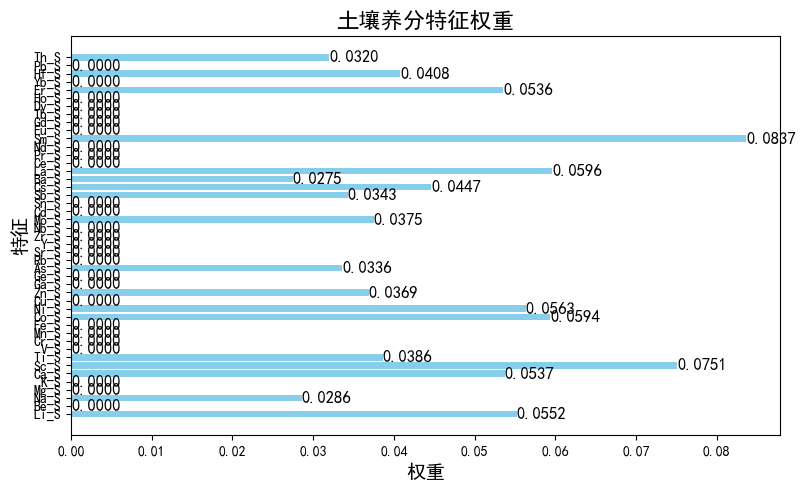

In [91]:
# 只画实际存在的土壤元素
soil_feats_in_data = [f for f in soil_elements if f in feature_names]
soil_idx = [feature_names.index(f) for f in soil_feats_in_data]
soil_weights = [wghts_final[i] for i in soil_idx]

plt.figure(figsize=(8, 5))
bars = plt.barh(soil_feats_in_data, soil_weights, color='skyblue')
plt.title('土壤养分特征权重', fontsize=16)
plt.xlabel('权重', fontsize=14)
plt.ylabel('特征', fontsize=14)
plt.tight_layout()

# 在条形图右侧显示数值
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', fontsize=12)

plt.show()

Top 20土壤养分特征及其权重：
Sm_S: 0.0837
Sc_S: 0.0751
La_S: 0.0596
Co_S: 0.0594
Ni_S: 0.0563
Li_S: 0.0552
Ca_S: 0.0537
Er_S: 0.0536
Cs_S: 0.0447
Hf_S: 0.0408
Ti_S: 0.0386
Mo_S: 0.0375
Zn_S: 0.0369
Sb_S: 0.0343
As_S: 0.0336
Th_S: 0.0320
Na_S: 0.0286
Ba_S: 0.0275
Sr_S: 0.0000
Sn_S: 0.0000


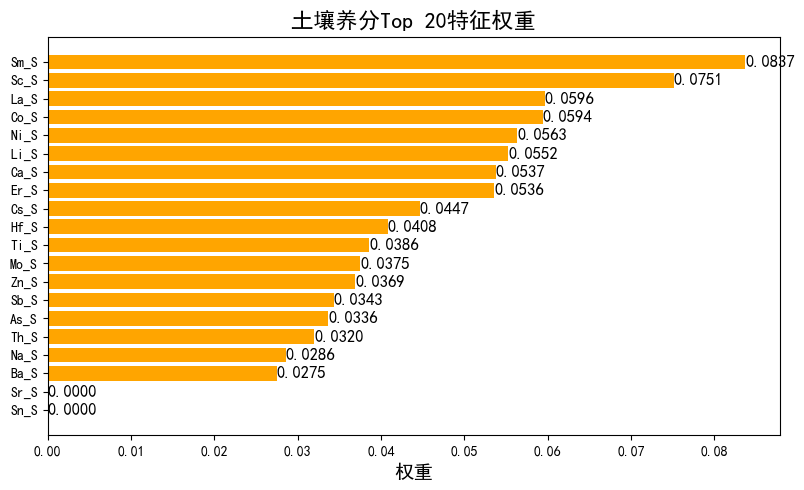

In [92]:
# soil_feats_in_data 和 soil_weights 已经准备好
N = 20
sorted_idx = np.argsort(-np.abs(soil_weights))[:N]
top_names = [soil_feats_in_data[i] for i in sorted_idx]
top_weights = [soil_weights[i] for i in sorted_idx]

# 打印Top 20特征及其权重
print("Top 20土壤养分特征及其权重：")
for name, weight in zip(top_names, top_weights):
    print(f"{name}: {weight:.4f}")

# 画图
plt.figure(figsize=(8, 5))
bars = plt.barh(top_names[::-1], top_weights[::-1], color='orange')
plt.title('土壤养分Top 20特征权重', fontsize=16)
plt.xlabel('权重', fontsize=14)
plt.tight_layout()
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', fontsize=12)
plt.show()

In [93]:
# for group_name, group_feats in groups:
#     # 只画实际存在于数据中的特征
#     feats_in_data = [f for f in group_feats if f in feature_names]
#     if not feats_in_data:
#         continue  # 跳过无特征的分组
#     idxs = [feature_names.index(f) for f in feats_in_data]
#     weights = [wghts_final[i] for i in idxs]
    
#     # 按绝对值从大到小排序
#     sorted_idx = np.argsort(-np.abs(weights))
#     sorted_feats = [feats_in_data[i] for i in sorted_idx]
#     sorted_weights = [weights[i] for i in sorted_idx]
    
#     plt.figure(figsize=(8, max(4, len(sorted_feats)*0.4)))
#     bars = plt.barh(sorted_feats[::-1], sorted_weights[::-1], color='skyblue')
#     plt.title(f'{group_name}特征权重', fontsize=16)
#     plt.xlabel('权重', fontsize=14)
#     plt.tight_layout()
#     for bar in bars:
#         width = bar.get_width()
#         plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', fontsize=12)
#     plt.show()

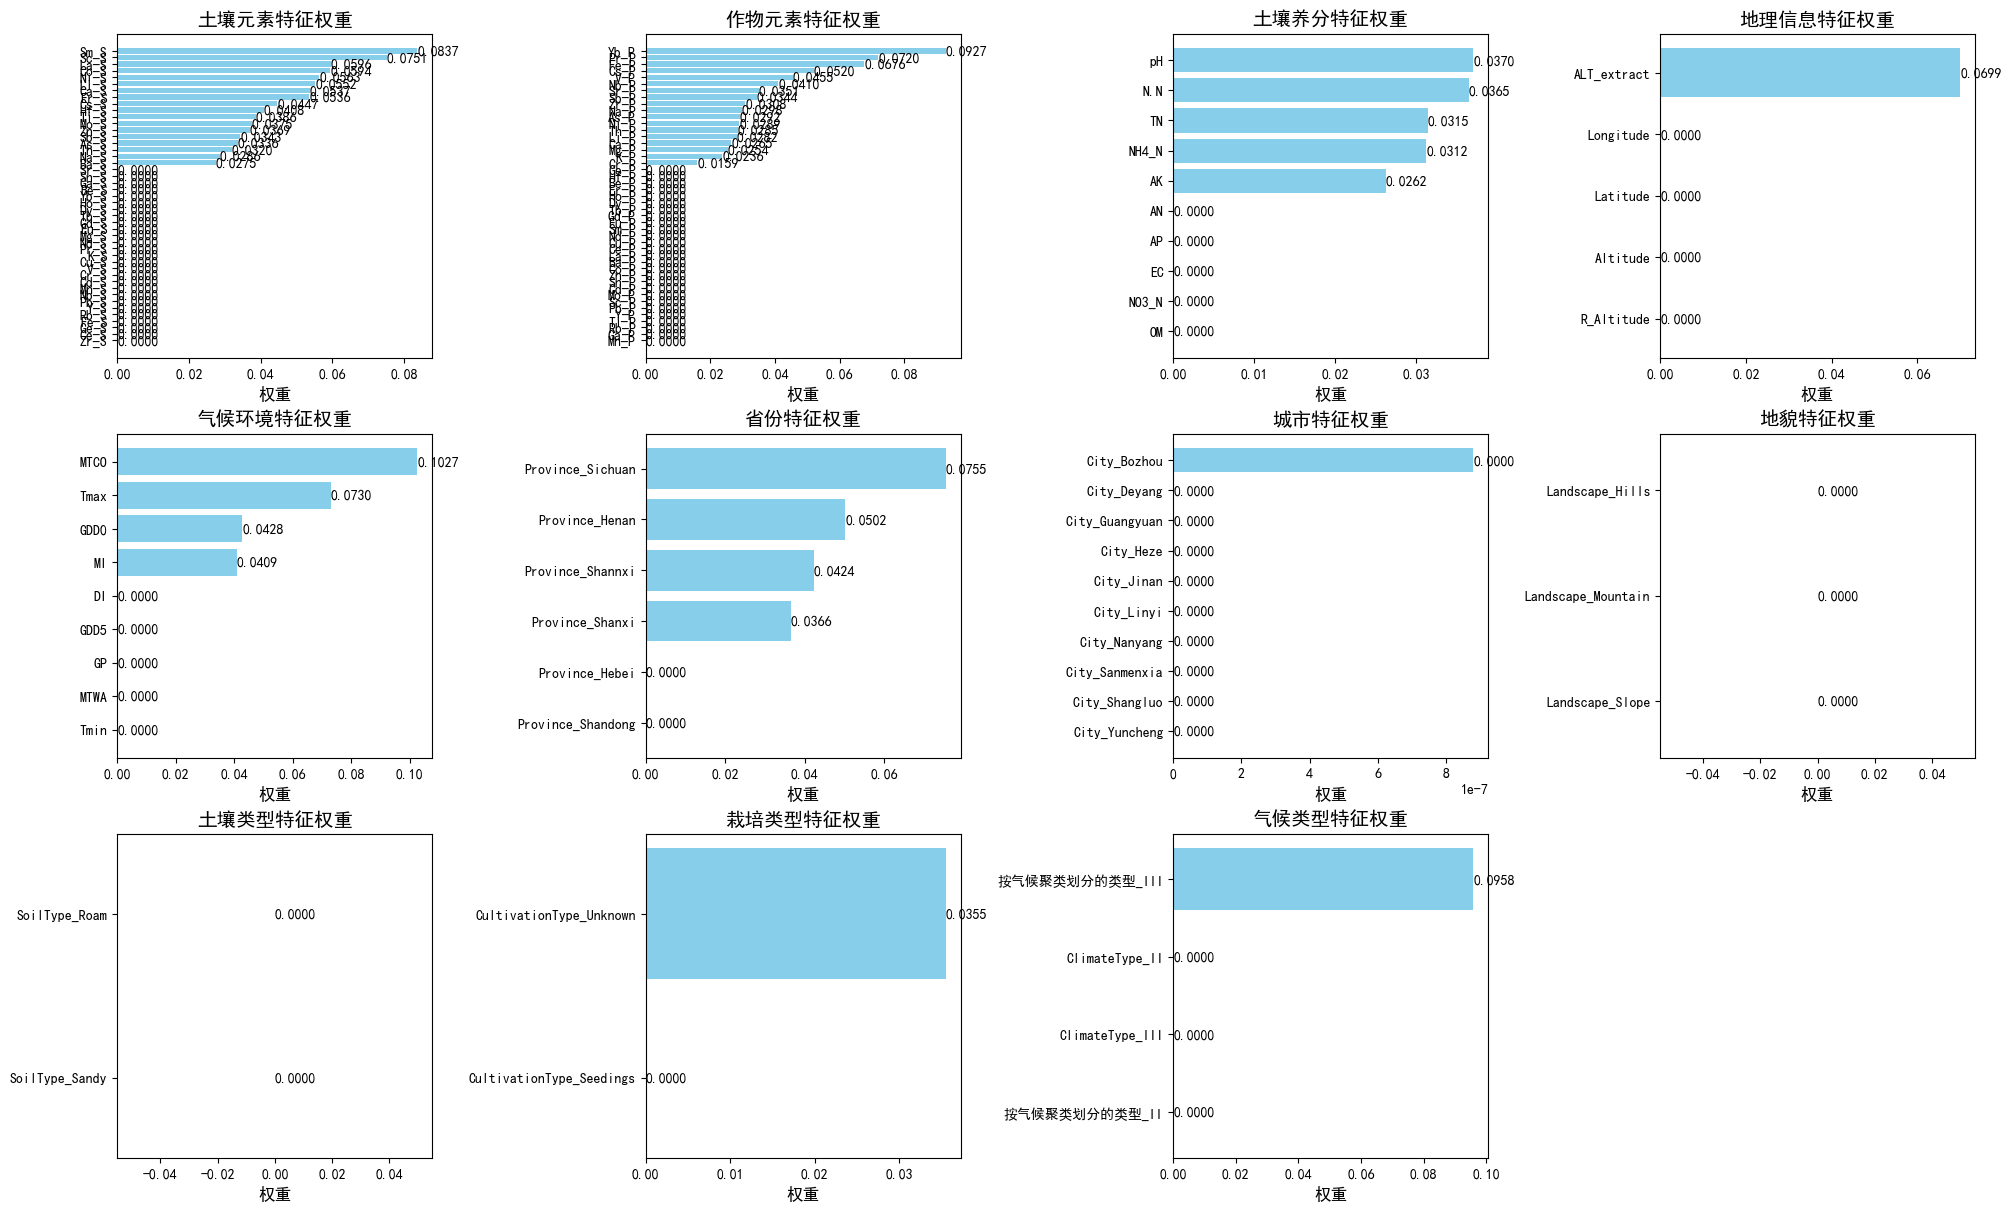

In [94]:
# 1. 统计实际有特征的分组
valid_groups = []
for group_name, group_feats in groups:
    feats_in_data = [f for f in group_feats if f in feature_names]
    if feats_in_data:
        valid_groups.append((group_name, feats_in_data))

n_groups = len(valid_groups)
nrows, ncols = 3, 4

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 12), constrained_layout=True)
axes = axes.flatten()  # 方便一维索引

# 2. 逐个分组画图
for i, (group_name, group_feats) in enumerate(valid_groups):
    ax = axes[i]
    idxs = [feature_names.index(f) for f in group_feats]
    weights = [wghts_final[i] for i in idxs]
    sorted_idx = np.argsort(-np.abs(weights))
    sorted_feats = [group_feats[j] for j in sorted_idx]
    sorted_weights = [weights[j] for j in sorted_idx]
    bars = ax.barh(sorted_feats[::-1], sorted_weights[::-1], color='skyblue')
    ax.set_title(f'{group_name}特征权重', fontsize=14)
    ax.set_xlabel('权重', fontsize=12)
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center', fontsize=10)

# 3. 隐藏多余的子图
for j in range(len(valid_groups), nrows*ncols):
    fig.delaxes(axes[j])

plt.show()

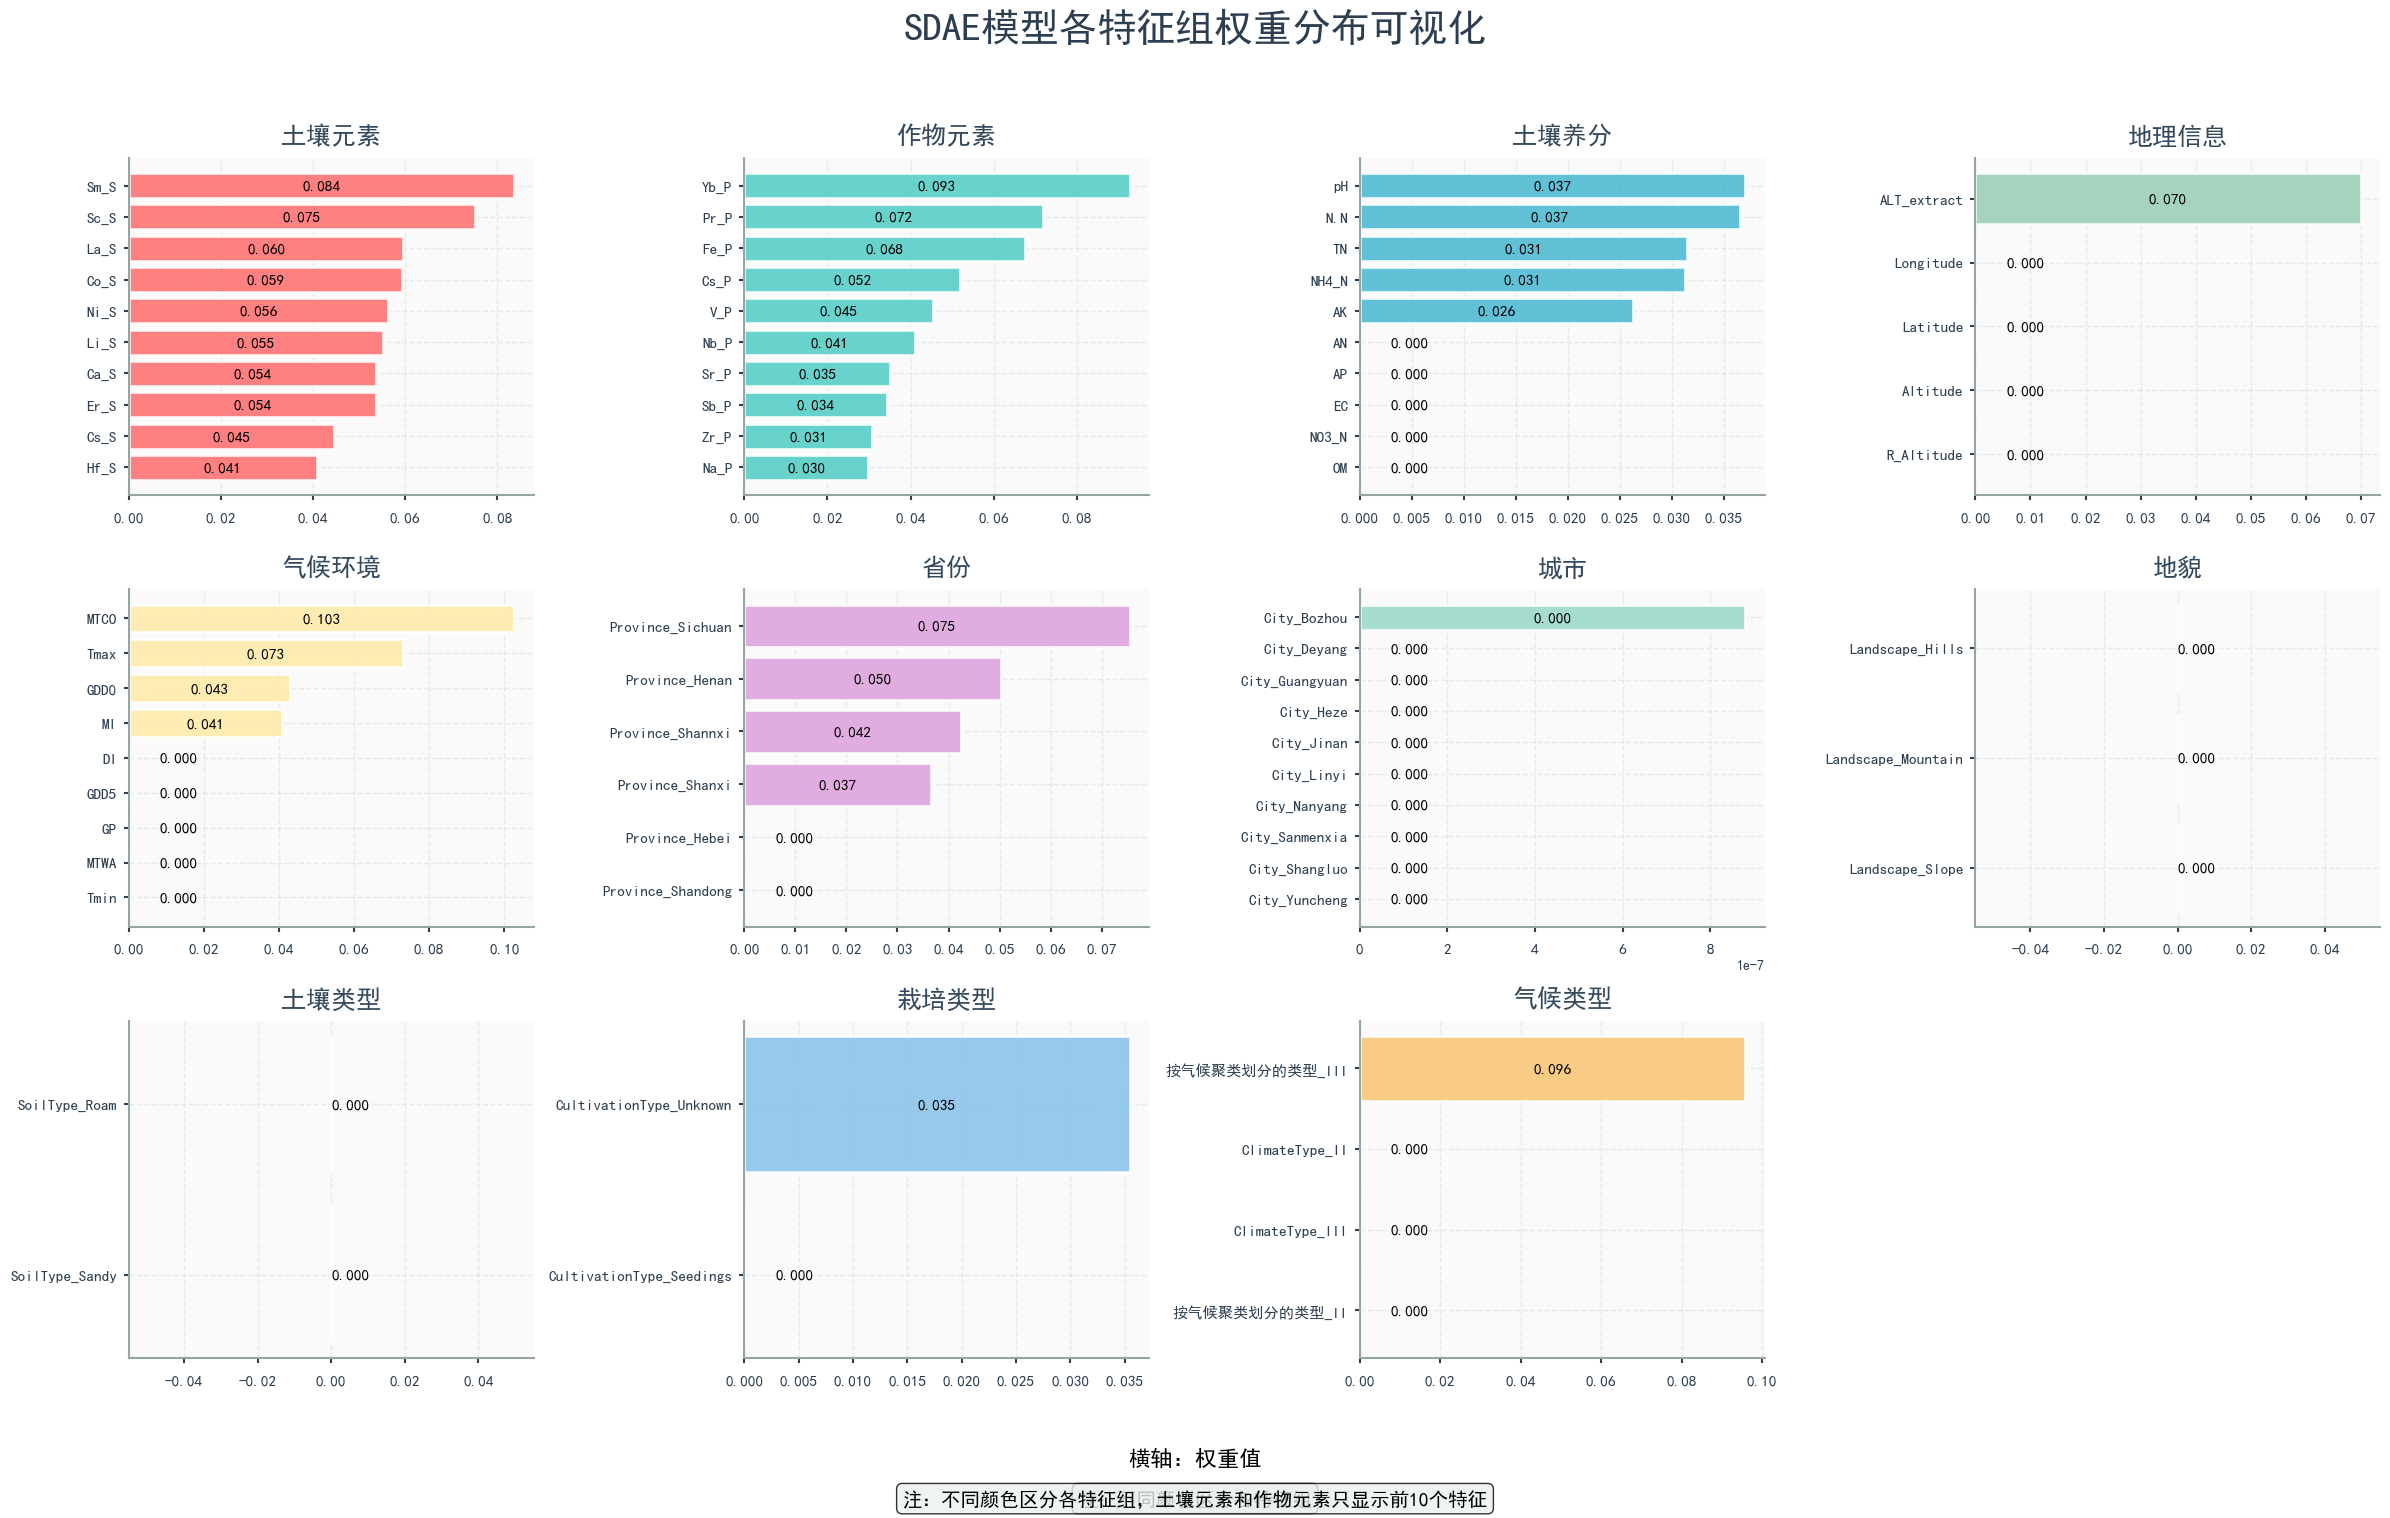

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 如果上面的字体不行，可以尝试这个
import matplotlib
matplotlib.font_manager.fontManager.addfont('C:/Windows/Fonts/simhei.ttf')  # Windows系统
plt.rcParams['font.family'] = ['SimHei']

# 创建美观的颜色方案
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', 
          '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9', '#F8C471', '#82E0AA']

# 统计实际有特征的分组
valid_groups = []
for group_name, group_feats in groups:
    feats_in_data = [f for f in group_feats if f in feature_names]
    if feats_in_data:
        valid_groups.append((group_name, feats_in_data))

n_groups = len(valid_groups)
nrows, ncols = 3, 4

# 创建图形
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16), facecolor='white')
fig.suptitle('SDAE模型各特征组权重分布可视化', fontsize=28, fontweight='bold', 
             y=0.95, color='#2C3E50')
axes = axes.flatten()

# 为每个子图绘制美观的条形图
for i, (group_name, group_feats) in enumerate(valid_groups):
    ax = axes[i]
    
    # 获取权重数据
    idxs = [feature_names.index(f) for f in group_feats]
    weights = [wghts_final[idx] for idx in idxs]
    
    # 按权重绝对值排序
    sorted_idx = np.argsort(-np.abs(weights))
    sorted_feats = [group_feats[j] for j in sorted_idx]
    sorted_weights = [weights[j] for j in sorted_idx]
    
    # 新增：对土壤元素和作物元素只显示前10个
    if group_name in ['土壤元素', '作物元素']:
        sorted_feats = sorted_feats[:10]
        sorted_weights = sorted_weights[:10]

    # 根据权重正负设置颜色
    bar_colors = [colors[i % len(colors)] for _ in sorted_weights]  # 统一颜色
    
    # 绘制水平条形图
    bars = ax.barh(range(len(sorted_feats)), sorted_weights[::-1], 
                   color=bar_colors[::-1], alpha=0.85, 
                   edgecolor='white', linewidth=2)
    
    # 设置y轴标签 - 确保中文显示
    ax.set_yticks(range(len(sorted_feats)))
    ax.set_yticklabels(sorted_feats[::-1], fontsize=48, fontweight='medium', 
                       fontfamily='SimHei')  # 明确指定中文字体
    
    # 设置标题和标签 - 确保中文显示
    ax.set_title(f'{group_name}', fontsize=18, fontweight='bold', 
                pad=10, color='#34495E', fontfamily='SimHei')
    ax.set_xlabel('特征权重值', fontsize=14, fontweight='medium', 
                  color='#2C3E50', fontfamily='SimHei')
    
    # 添加精美网格
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=1, color='#BDC3C7')
    ax.set_axisbelow(True)
    
    
    # # 只在最下面一排的子图显示x轴标签
    # if i >= (nrows-1) * ncols:  # 最下面一排
    #     ax.set_xlabel('权重值', fontsize=14, fontweight='medium', 
    #                   color='black', fontfamily='SimHei')
    # else:
    #     ax.set_xlabel('')  # 其他子图不显示x轴标签
        
     # 所有子图都不显示x轴标签
    ax.set_xlabel('')
        
    
    # 在条形上添加数值标注 - 修改：数值颜色改为黑色
    for j, (bar, weight) in enumerate(zip(bars, sorted_weights[::-1])):
        width = bar.get_width()
        if abs(width) > max(abs(min(sorted_weights)), abs(max(sorted_weights))) * 0.15:
            ax.text(width/2, bar.get_y() + bar.get_height()/2, 
                   f'{width:.3f}', ha='center', va='center', 
                   fontsize=11, fontweight='bold', color='black')  # 改为黑色
        else:
            offset = max(abs(min(sorted_weights)), abs(max(sorted_weights))) * 0.08
            ax.text(width + offset if width >= 0 else width - offset, 
                   bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', ha='left' if width >= 0 else 'right', va='center',
                   fontsize=11, fontweight='medium', color='black')  # 改为黑色
    
    # 美化坐标轴
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#95A5A6')
    ax.spines['bottom'].set_color('#95A5A6')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    # 美化刻度
    ax.tick_params(colors='#2C3E50', labelsize=11, width=1.5)
    ax.tick_params(axis='x', pad=8)
    ax.tick_params(axis='y', pad=5)
    
    # 设置背景色
    ax.set_facecolor('#FAFAFA')

# 隐藏多余的子图
for j in range(len(valid_groups), nrows*ncols):
    axes[j].set_visible(False)

# 调整布局
plt.tight_layout(rect=[0, 0.03, 1, 0.92])


# 调整布局时留出更多底部空间
plt.tight_layout(rect=[0, 0.08, 1, 0.92])  # 底部留更多空间

# 在图的底部添加统一的权重值说明
fig.text(0.5, 0.04, '横轴：权重值', ha='center', fontsize=16, 
         fontweight='bold', color='black', fontfamily='SimHei')

# 原来的底部说明文字位置稍微上移
fig.text(0.5, 0.015, '注：不同颜色区分各特征组', 
         ha='center', fontsize=14, style='italic', color='black',
         fontfamily='SimHei',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='#ECF0F1', alpha=0.8))


# 修改底部说明文字 - 去掉负权重说明
fig.text(0.5, 0.015, '注：不同颜色区分各特征组，土壤元素和作物元素只显示前10个特征', 
         ha='center', fontsize=14, style='italic', color='black',
         fontfamily='SimHei',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='#ECF0F1', alpha=0.8))


plt.show()

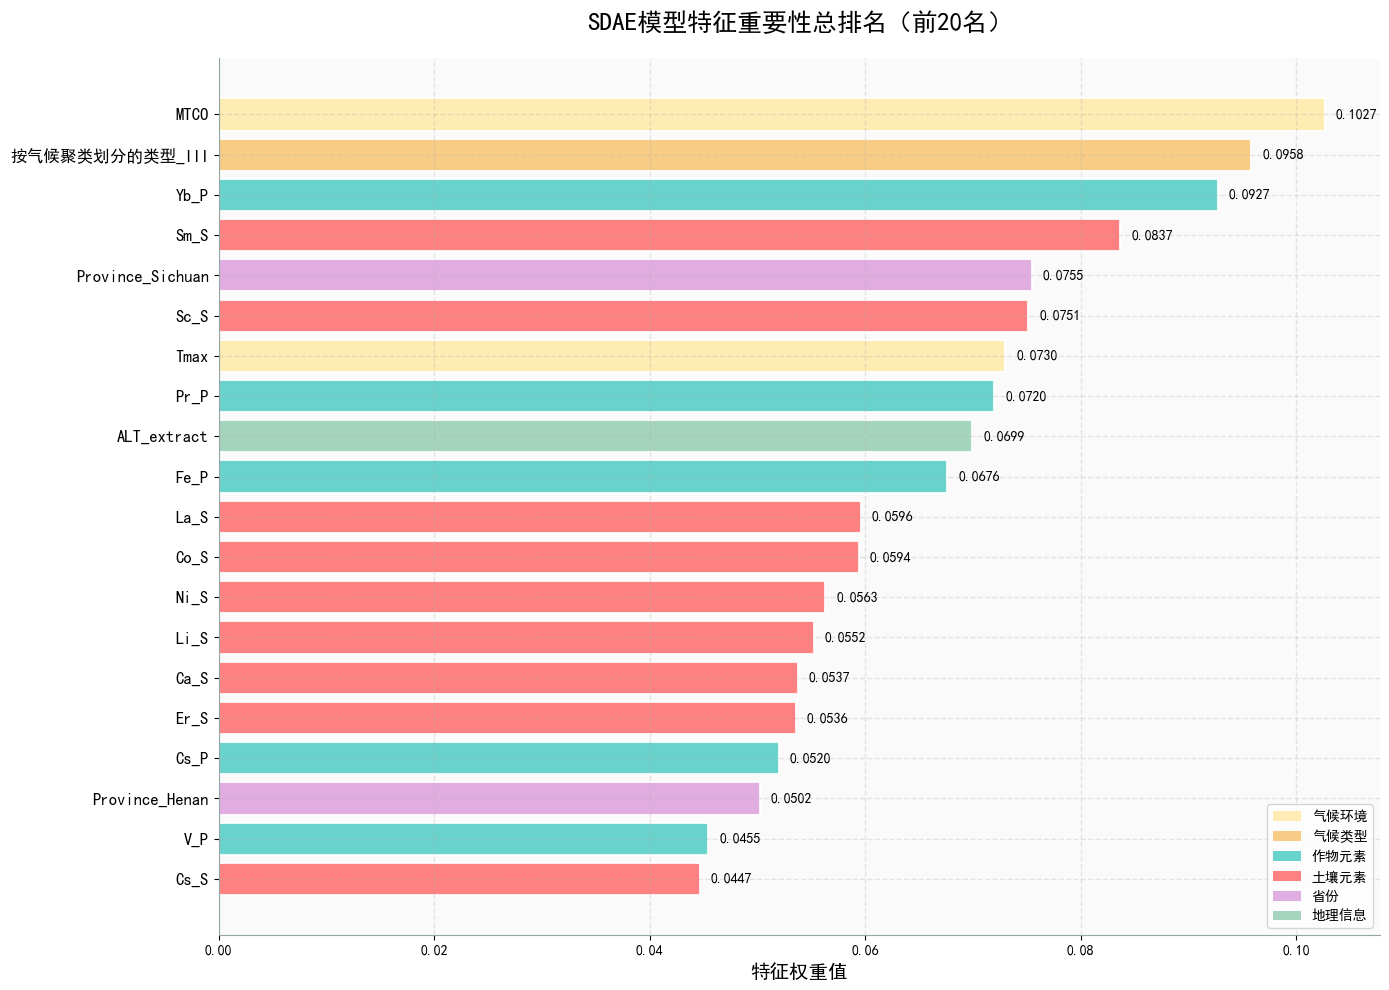

SDAE模型特征重要性总排名（前20名）
排名   特征名称                      权重值        所属组         
--------------------------------------------------------------------------------
1    MTCO                      0.1027     气候环境        
2    按气候聚类划分的类型_III            0.0958     气候类型        
3    Yb_P                      0.0927     作物元素        
4    Sm_S                      0.0837     土壤元素        
5    Province_Sichuan          0.0755     省份          
6    Sc_S                      0.0751     土壤元素        
7    Tmax                      0.0730     气候环境        
8    Pr_P                      0.0720     作物元素        
9    ALT_extract               0.0699     地理信息        
10   Fe_P                      0.0676     作物元素        
11   La_S                      0.0596     土壤元素        
12   Co_S                      0.0594     土壤元素        
13   Ni_S                      0.0563     土壤元素        
14   Li_S                      0.0552     土壤元素        
15   Ca_S                      0.0537     土壤元素        
16   Er_S         

In [96]:
# 生成总的特征重要性排名（前20个）
import matplotlib.pyplot as plt
import numpy as np

# 获取所有特征的权重
all_weights = wghts_final
all_features = feature_names

# 按权重绝对值排序，获取前20个
sorted_indices = np.argsort(-np.abs(all_weights))[:20]
top_features = [all_features[i] for i in sorted_indices]
top_weights = [all_weights[i] for i in sorted_indices]

# 为每个特征分配所属组的颜色
feature_colors = []
group_color_map = {}
for i, (group_name, group_feats) in enumerate(groups):
    group_color_map[group_name] = colors[i % len(colors)]

for feature in top_features:
    # 找到特征所属的组
    feature_group = '其他'
    for group_name, group_feats in groups:
        if feature in group_feats:
            feature_group = group_name
            break
    
    if feature_group in group_color_map:
        feature_colors.append(group_color_map[feature_group])
    else:
        feature_colors.append('#95A5A6')  # 默认颜色

# 创建图形
plt.figure(figsize=(14, 10))

# 绘制水平条形图
bars = plt.barh(range(len(top_features)), top_weights[::-1], 
                color=feature_colors[::-1], alpha=0.85, 
                edgecolor='white', linewidth=1.5)

# 设置标签
plt.yticks(range(len(top_features)), top_features[::-1], fontsize=12, fontfamily='SimHei')
plt.xlabel('特征权重值', fontsize=14, fontweight='bold', fontfamily='SimHei')
plt.title('SDAE模型特征重要性总排名（前20名）', fontsize=18, fontweight='bold', 
          pad=20, fontfamily='SimHei')

# 添加网格
plt.grid(True, alpha=0.3, linestyle='--', linewidth=1)

# 在条形上添加数值
for i, (bar, weight) in enumerate(zip(bars, top_weights[::-1])):
    width = bar.get_width()
    plt.text(width + max(abs(min(top_weights)), abs(max(top_weights))) * 0.01, 
             bar.get_y() + bar.get_height()/2,
             f'{weight:.4f}', ha='left', va='center',
             fontsize=10, fontweight='medium')

# 美化图形
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('#95A5A6')
plt.gca().spines['bottom'].set_color('#95A5A6')
plt.gca().set_facecolor('#FAFAFA')

# 创建图例
unique_groups = []
unique_colors = []
for feature in top_features:
    for group_name, group_feats in groups:
        if feature in group_feats and group_name not in unique_groups:
            unique_groups.append(group_name)
            unique_colors.append(group_color_map[group_name])
            break

legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.85, label=group) 
                   for group, color in zip(unique_groups, unique_colors)]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10, 
           prop={'family': 'SimHei'}, frameon=True, fancybox=True)

plt.tight_layout()
plt.show()

# 打印排名表格
print("=" * 80)
print("SDAE模型特征重要性总排名（前20名）")
print("=" * 80)
print(f"{'排名':<4} {'特征名称':<25} {'权重值':<10} {'所属组':<12}")
print("-" * 80)

for rank, (feature, weight) in enumerate(zip(top_features, top_weights), 1):
    # 找到特征所属组
    feature_group = '其他'
    for group_name, group_feats in groups:
        if feature in group_feats:
            feature_group = group_name
            break
    
    print(f"{rank:<4} {feature:<25} {weight:<10.4f} {feature_group:<12}")

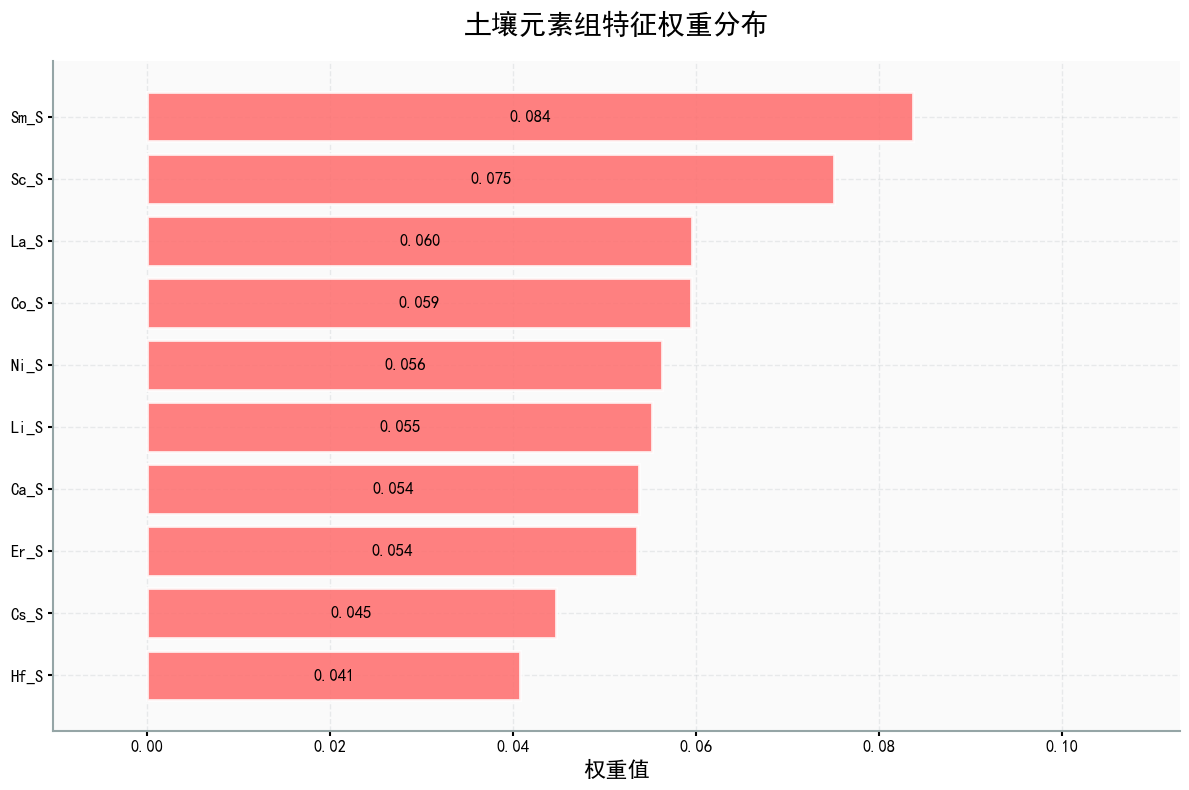

已显示：土壤元素组特征权重图


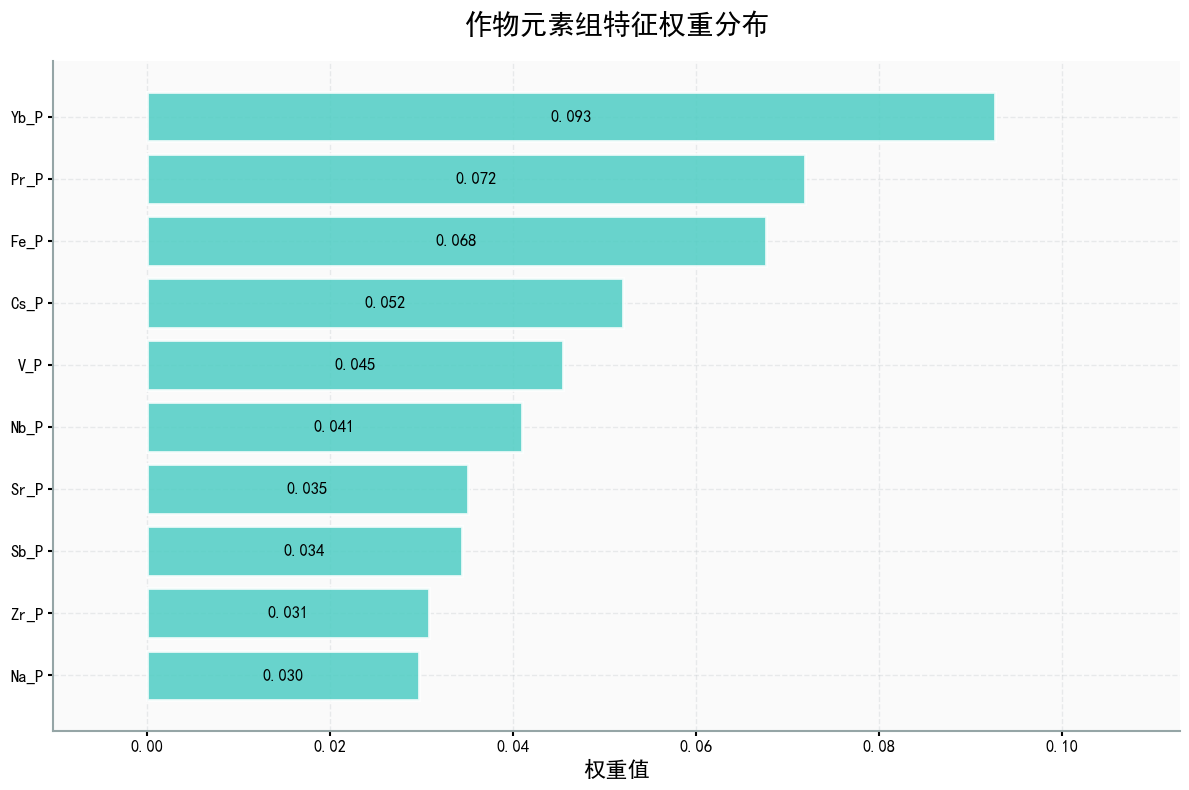

已显示：作物元素组特征权重图


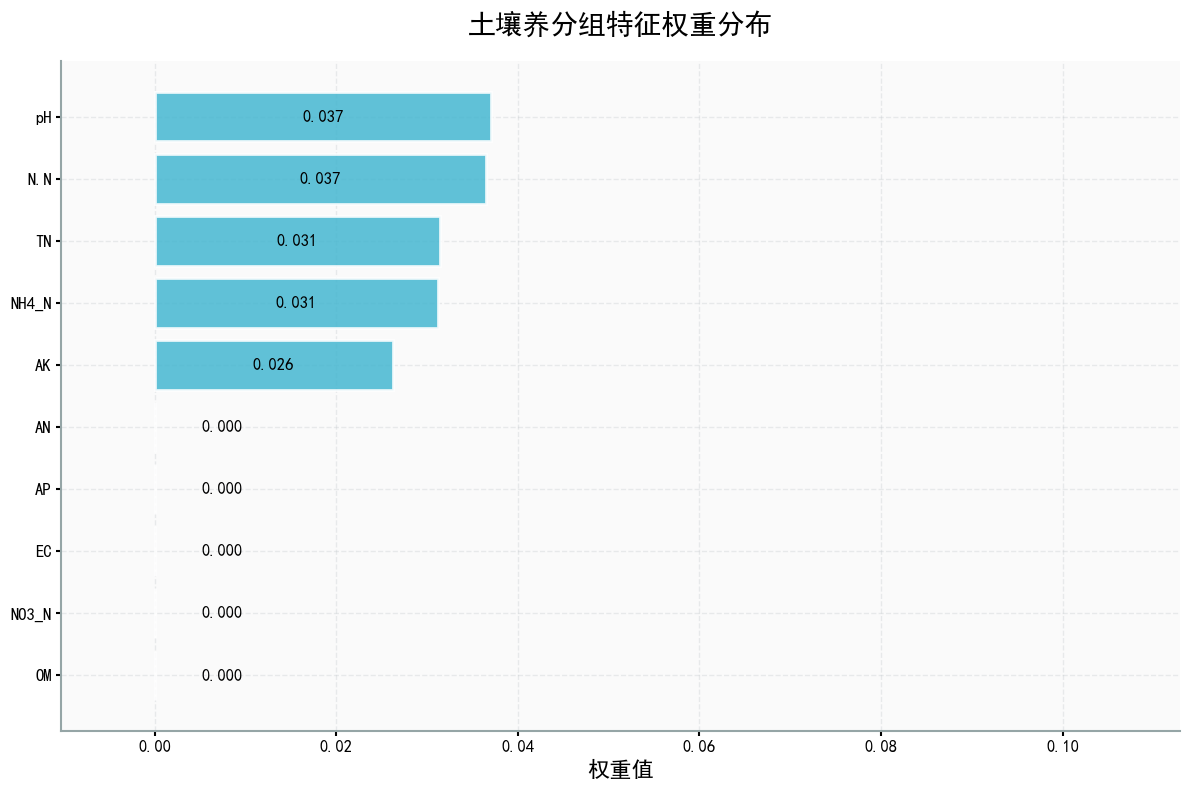

已显示：土壤养分组特征权重图


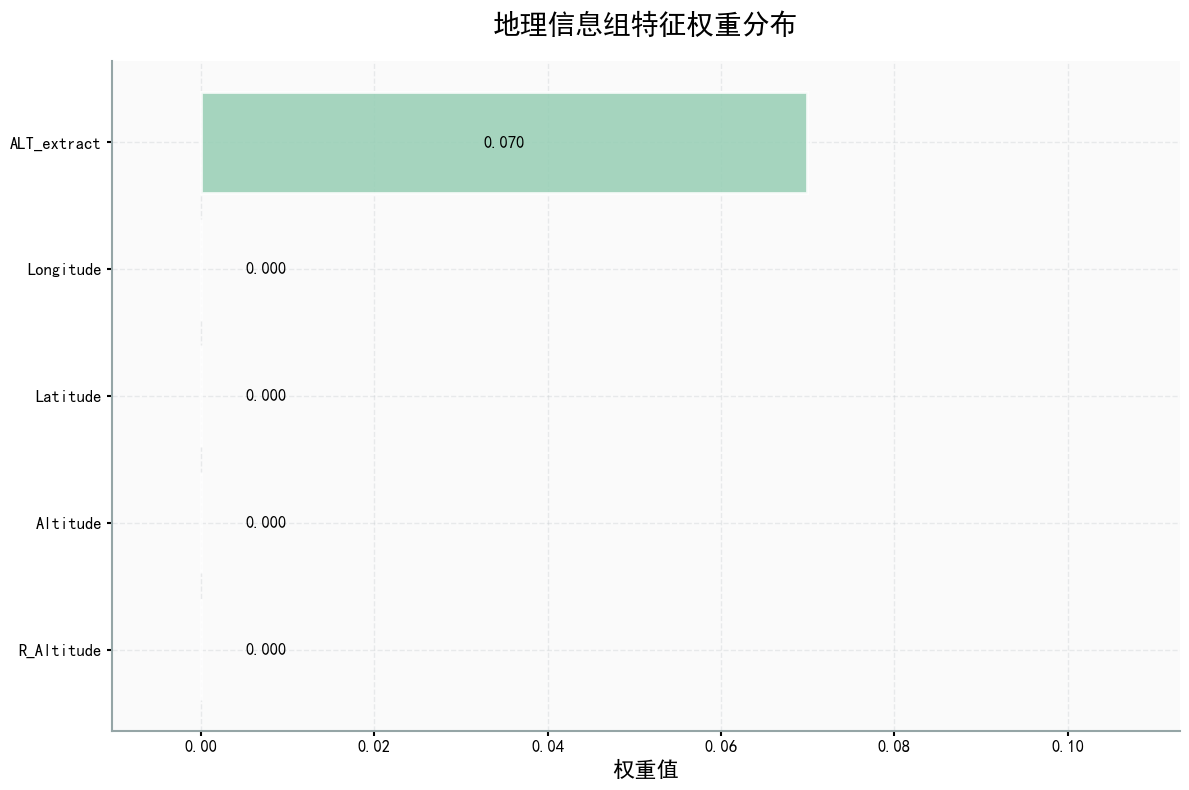

已显示：地理信息组特征权重图


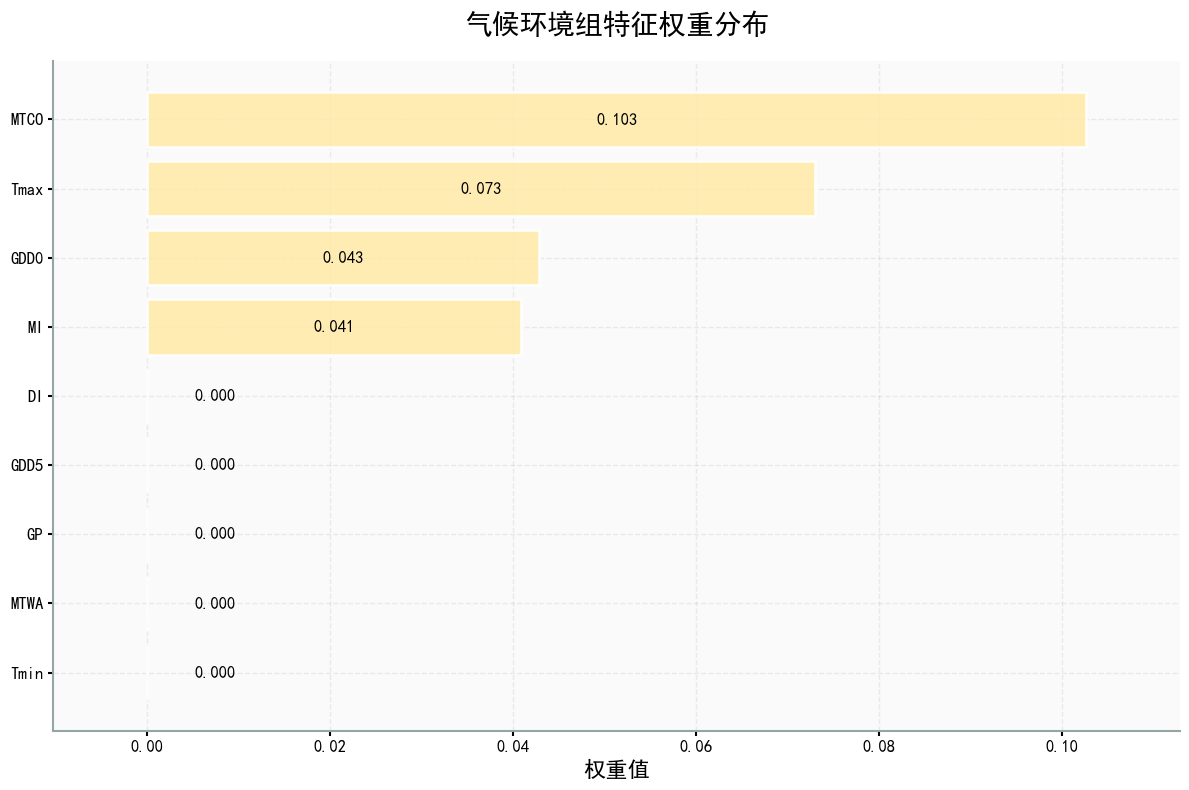

已显示：气候环境组特征权重图


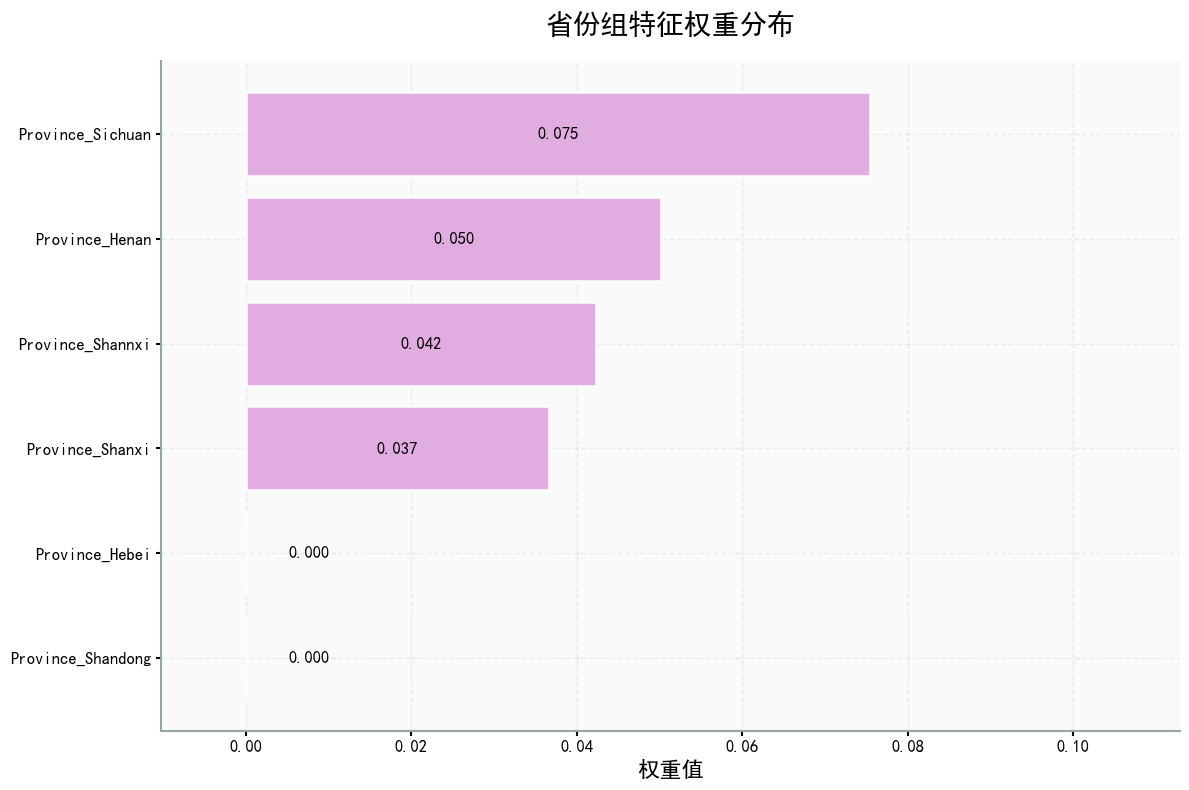

已显示：省份组特征权重图


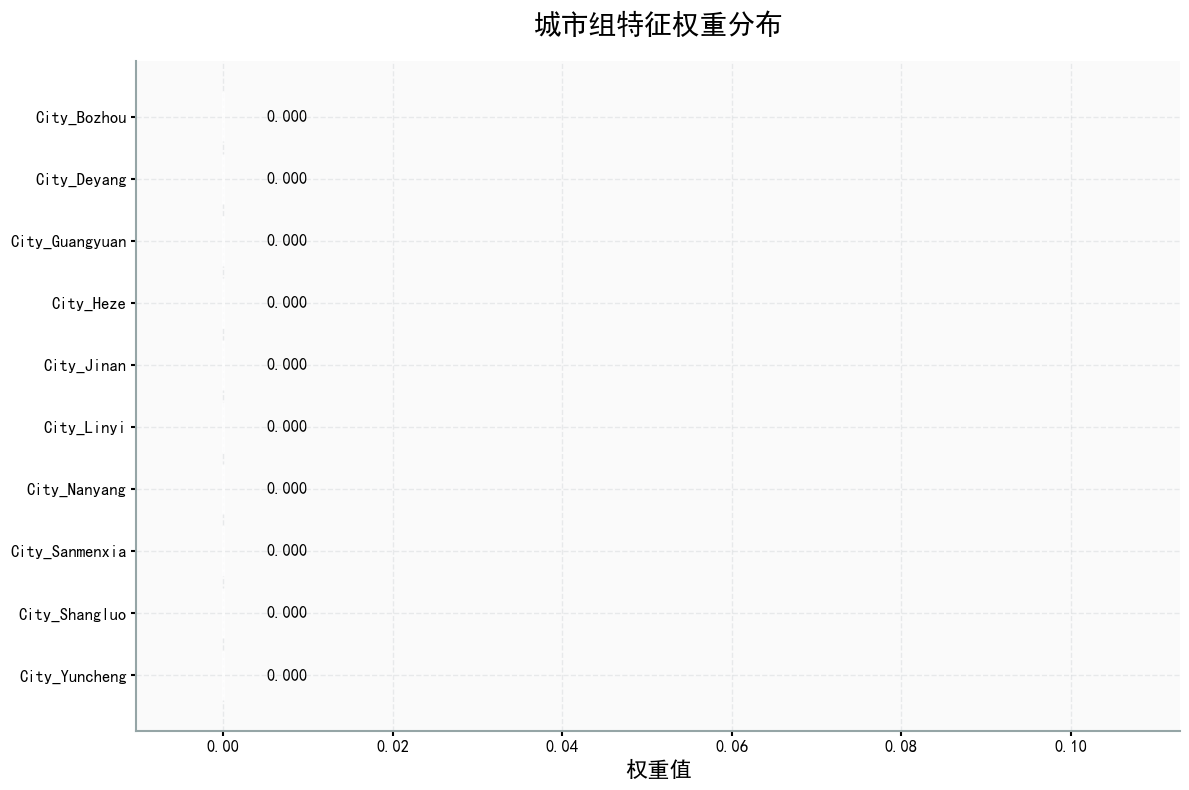

已显示：城市组特征权重图


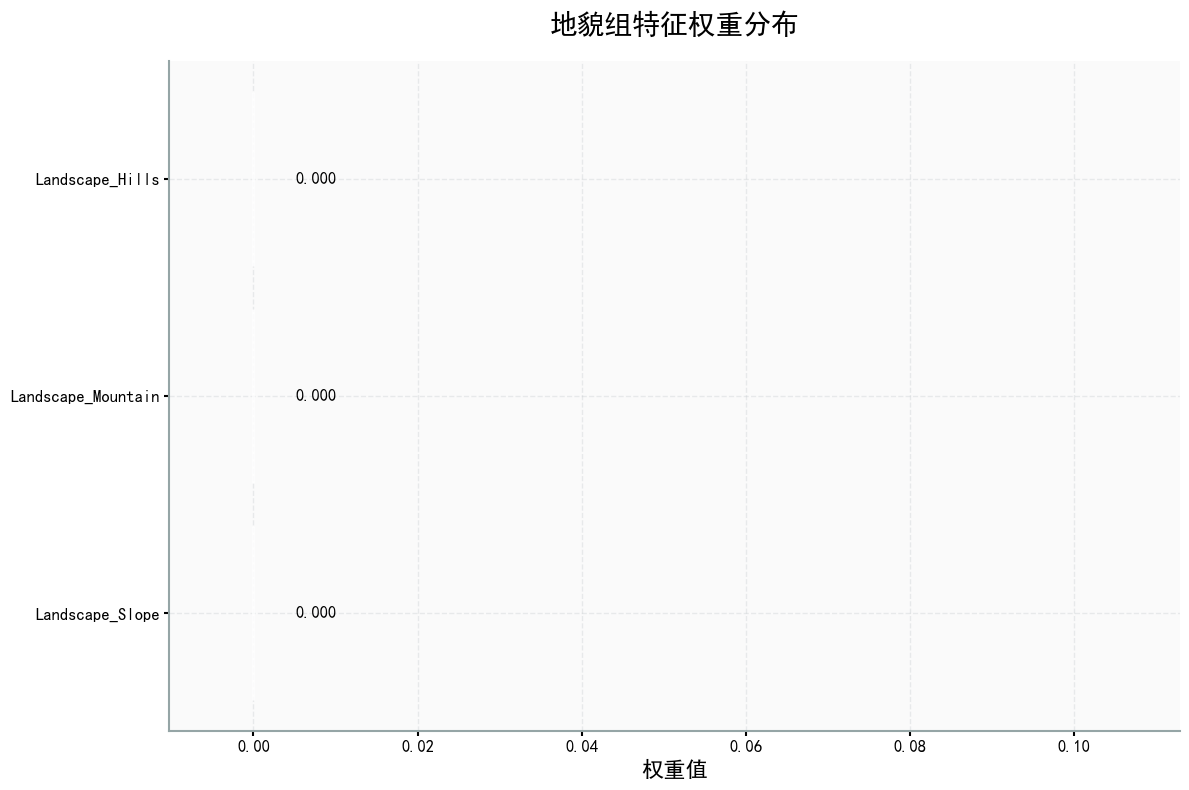

已显示：地貌组特征权重图


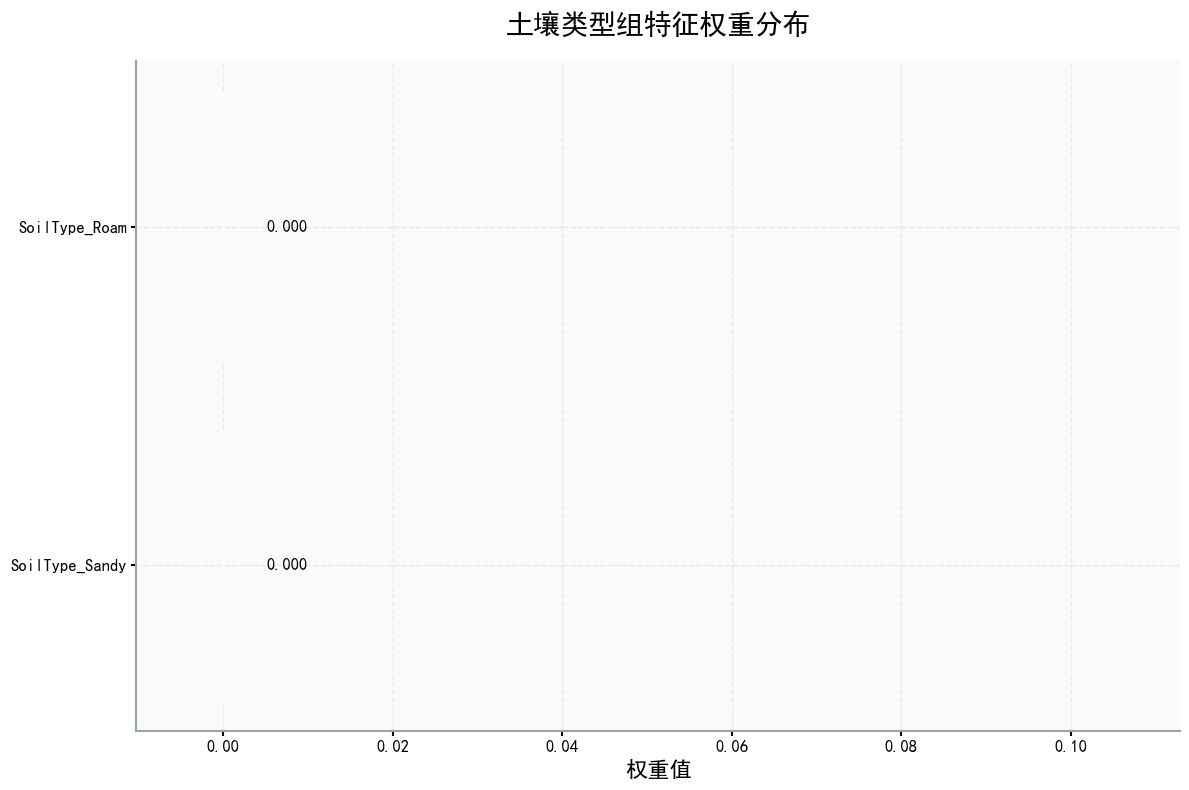

已显示：土壤类型组特征权重图


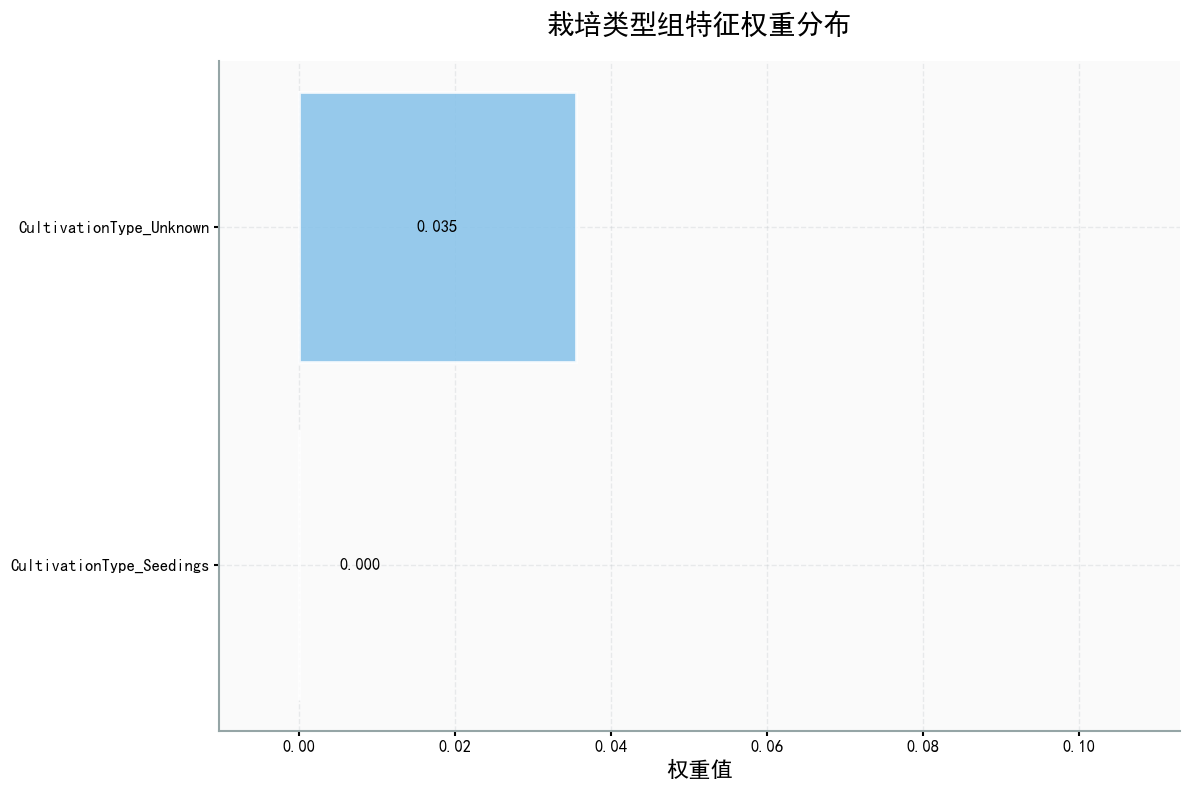

已显示：栽培类型组特征权重图


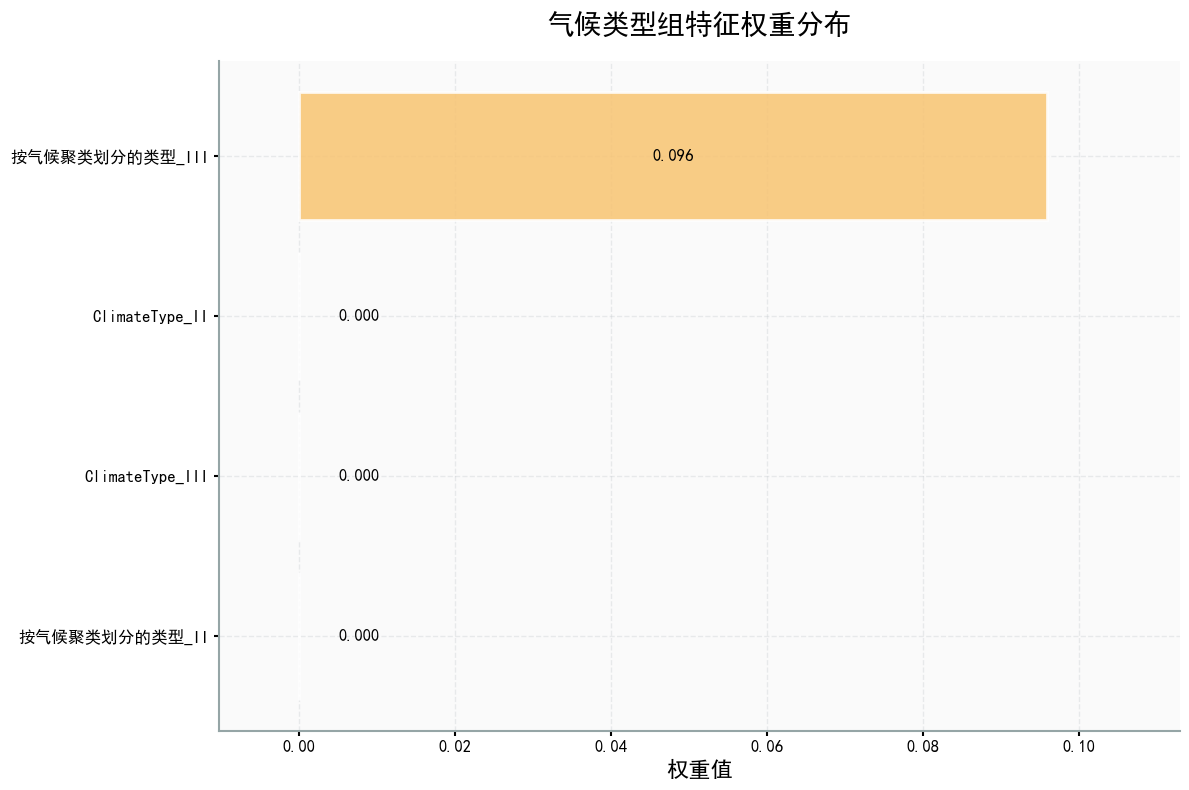

已显示：气候类型组特征权重图


In [97]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 颜色方案
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', 
          '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9', '#F8C471', '#82E0AA']

# 统计实际有特征的分组
valid_groups = []
for group_name, group_feats in groups:
    feats_in_data = [f for f in group_feats if f in feature_names]
    if feats_in_data:
        valid_groups.append((group_name, feats_in_data))

# 计算全局权重范围（用于统一坐标轴）
all_weights_for_display = []
for group_name, group_feats in valid_groups:
    idxs = [feature_names.index(f) for f in group_feats]
    weights = [wghts_final[idx] for idx in idxs]
    
    if group_name in ['土壤元素', '作物元素']:
        sorted_idx = np.argsort(-np.abs(weights))[:10]
        weights = [weights[j] for j in sorted_idx]
    
    all_weights_for_display.extend(weights)

global_min = min(all_weights_for_display)
global_max = max(all_weights_for_display)
margin = (global_max - global_min) * 0.1
x_min = global_min - margin
x_max = global_max + margin

# 为每个特征组单独创建图表
for i, (group_name, group_feats) in enumerate(valid_groups):
    # 创建单独的图形
    plt.figure(figsize=(12, 8))
    
    # 获取权重数据
    idxs = [feature_names.index(f) for f in group_feats]
    weights = [wghts_final[idx] for idx in idxs]
    
    # 按权重绝对值排序
    sorted_idx = np.argsort(-np.abs(weights))
    sorted_feats = [group_feats[j] for j in sorted_idx]
    sorted_weights = [weights[j] for j in sorted_idx]
    
    # 对土壤元素和作物元素只显示前10个
    if group_name in ['土壤元素', '作物元素']:
        sorted_feats = sorted_feats[:10]
        sorted_weights = sorted_weights[:10]
    
    # 统一使用组颜色
    bar_colors = [colors[i % len(colors)] for _ in sorted_weights]
    
    # 绘制水平条形图
    bars = plt.barh(range(len(sorted_feats)), sorted_weights[::-1], 
                    color=bar_colors[::-1], alpha=0.85, 
                    edgecolor='white', linewidth=2)
    
    # 设置标签
    plt.yticks(range(len(sorted_feats)), sorted_feats[::-1], 
               fontsize=14, fontweight='medium', fontfamily='SimHei', color='black')
    plt.xlabel('权重值', fontsize=16, fontweight='medium', color='black', fontfamily='SimHei')
    plt.title(f'{group_name}组特征权重分布', fontsize=20, fontweight='bold', 
              pad=20, color='black', fontfamily='SimHei')
    
    # 设置统一的x轴范围
    plt.xlim(x_min, x_max)
    
    # 添加网格
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=1, color='#BDC3C7')
    plt.gca().set_axisbelow(True)
    
    # 在条形上添加数值标注
    for j, (bar, weight) in enumerate(zip(bars, sorted_weights[::-1])):
        width = bar.get_width()
        if abs(width) > (global_max - global_min) * 0.15:
            plt.text(width/2, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='center', va='center', 
                    fontsize=12, fontweight='bold', color='black')
        else:
            offset = (global_max - global_min) * 0.05
            plt.text(width + offset if width >= 0 else width - offset, 
                    bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}', ha='left' if width >= 0 else 'right', va='center',
                    fontsize=12, fontweight='medium', color='black')
    
    # 美化图形
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('#95A5A6')
    plt.gca().spines['bottom'].set_color('#95A5A6')
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().set_facecolor('#FAFAFA')
    plt.gca().tick_params(colors='black', labelsize=12, width=1.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"已显示：{group_name}组特征权重图")